# Import python packages

In [45]:
# import Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import linear_model
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, confusion_matrix
from scipy import stats
import warnings
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors
from scipy.stats import lognorm
import math
import statsmodels.api as sm
from matplotlib.cm import get_cmap

from sklearn.datasets import load_iris
from sklearn.utils import resample
from scipy.stats import norm
#from plotnine import *

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.dpi'] = 200

# Read data

In [46]:
# load data
data = pd.read_csv('EQgate_geometries.csv')
feature = data["Feature"].unique()
print(feature)
grouped = data.groupby(data.Feature)


['bend' 'gap' 'splay' 'stepover' 'strand']


In [47]:
data.head()

,FDHI ID,Earthquake,Date,Magnitude,Cumulative displacement,Style,Hypocenter lat,Hypocenter lon,Feature,Breached or unbreached,...,Type (length or angle),Location along rupture,Total rupture length,Normalized location,Distance to epicenter,x1check,y1check,UTM zone,latcheck,loncheck
0,4,Balochistan,'2013-09-24',7.7,450.0,Strike-Slip,26.951,65.501,bend,breached,...,angle,189199.980416,199115.277475,0.950203,27391.059205,753335.921888,3.010388e+06,41N,27.192918,65.557280
1,4,Balochistan,'2013-09-24',7.7,450.0,Strike-Slip,26.951,65.501,bend,breached,...,angle,85999.993400,199115.277475,0.431911,76876.920291,695025.678250,2.928032e+06,41N,26.459285,64.956183
2,4,Balochistan,'2013-09-24',7.7,450.0,Strike-Slip,26.951,65.501,bend,breached,...,angle,77299.994037,199115.277475,0.388217,85397.473473,687771.916748,2.923215e+06,41N,26.416788,64.882750
3,4,Balochistan,'2013-09-24',7.7,450.0,Strike-Slip,26.951,65.501,bend,breached,...,angle,182299.981467,199115.277475,0.915550,21242.879921,749551.207690,3.004671e+06,41N,27.142044,65.517948
4,4,Balochistan,'2013-09-24',7.7,450.0,Strike-Slip,26.951,65.501,bend,breached,...,angle,86299.993386,199115.277475,0.433417,76888.287686,696152.113435,2.926956e+06,41N,26.449417,64.967311


# Quickly play around with data
e.g. find largest restraining step-over

In [48]:
# grouped = grouped.get_group('splay')
# print(len(grouped))

# # Filter rows where "Type (releasing or restraining)" is 'restraining'
# restraining_rows = grouped[grouped["Type (releasing or restraining)"] == 'restraining']

# # Filter rows where "Breached or unbreached" is 'breached'
# breached_rows = restraining_rows[restraining_rows["Breached or unbreached"] == 'breached']

# # Find location and value of the largest entry in "Length (m) or angle (deg)"
# max_length_or_angle = breached_rows["Length (m) or angle (deg)"].max()
# largest_entry = breached_rows.loc[breached_rows["Length (m) or angle (deg)"].idxmax()]

# print(largest_entry)
# print(max_length_or_angle)

# functions required to analyze data and estimate passing probabilities

Function to generate logistic models for all of the earthquake gates in this study:

In [49]:
def bootstrap_errors(xfeature, BUbin, classweightb, ax, minx, maxx, colorline, n_iterations=10000):
    logistic_reg = []

    for i in range(n_iterations):
        # Reset the index of the dataframes (if they are pandas DataFrames or Series)
        if isinstance(xfeature, pd.DataFrame):
            xfeature.reset_index(drop=True, inplace=True)
        if isinstance(BUbin, pd.DataFrame):
            BUbin.reset_index(drop=True, inplace=True)

        # Define the desired resampling ratio (e.g., 100% for bootstrap)
        resample_ratio = 1.0

        # Calculate the number of samples to keep based on the ratio
        num_samples_to_keep = int(len(xfeature) * resample_ratio)

        # Generate random indices for resampling with replacement
        selected_indices = np.random.choice(len(xfeature), num_samples_to_keep, replace=True)

        # Use the selected indices to extract the resampled data
        resampled_xfeature = xfeature.iloc[selected_indices]
        resampled_BUbin = BUbin.iloc[selected_indices]

        if len(resampled_BUbin.unique()) < 2:
           # print("Skipping iteration because there is only one class in BUbin")
            continue  # Skip the iteration of the outer loop


        # Fit a logistic regression model to the bootstrap sample
        
        probname = sklearn.linear_model.LogisticRegression(penalty='none', class_weight=classweightb).fit(
            np.atleast_2d(resampled_xfeature).T, resampled_BUbin
        )


        # Plot passing probability
        x = np.atleast_2d(np.linspace(minx, maxx, 10000)).T
        # ax.plot(x, probname.predict_proba(x)[:, 1], color=colorline, alpha=0.001)
        logistic_reg.append(probname.predict_proba(x)[:, 1])
    
    percentiles_2_5 = np.percentile(logistic_reg, 2.5, axis=0) # 34
    percentiles_97_5 = np.percentile(logistic_reg, 97.5, axis=0) # 68
    xi = np.linspace(minx, maxx, 10000)
    ax.fill_between(xi, percentiles_2_5, percentiles_97_5, color='slategray', alpha=0.2)
    return logistic_reg


In [50]:
def build_regression(
        groupid, 
        stress_typeYN, 
        length_or_angle, 
        class_weightb, 
        truncateYN, 
        color_details_line, 
        color_details_scatter,
        axesid,minx,maxx,colorline,xlabel,ptsize
        ):
    
    EQgate = grouped.get_group(groupid)

    if stress_typeYN  == 'restraining':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('restraining')
        feature = group['Length (m) or angle (deg)']
        BUbin = pd.get_dummies(group['Breached or unbreached'])
        BUbin = BUbin['unbreached']

    elif stress_typeYN  == 'releasing':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('releasing')
        feature = group['Length (m) or angle (deg)']
        BUbin = pd.get_dummies(group['Breached or unbreached'])
        BUbin = BUbin['unbreached']
    
    elif stress_typeYN == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('single')
        feature = group['Length (m) or angle (deg)']
        BUbin = pd.get_dummies(group['Breached or unbreached'])
        BUbin = BUbin['unbreached']

    elif stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        feature = group['Length (m) or angle (deg)']
        BUbin = pd.get_dummies(group['Breached or unbreached'])
        BUbin = BUbin['unbreached']

    else:
        group = EQgate 
        feature = EQgate['Length (m) or angle (deg)']
        group['logfeature'] = np.log10(group['Length (m) or angle (deg)'].astype('float'))
        BUbin = pd.get_dummies(EQgate['Breached or unbreached'])
        BUbin = BUbin['unbreached']
    
    if length_or_angle == 'length':
        group['logfeature'] = np.log10(group['Length (m) or angle (deg)'].astype('float')) 
        xfeature = group['logfeature']
        minx = np.log10(minx)
        maxx = np.log10(maxx)

    elif length_or_angle == 'angle':
        group['logfeature'] = group['Length (m) or angle (deg)']
        xfeature = group['Length (m) or angle (deg)']
    else: 
        KeyError("Feature must include a length or an angle")

    # now we plot the data and fit the model:    
    #sns.regplot(x=xfeature,y=BUbin,y_jitter=0.1,data=EQgate,ci=None,logistic=True, truncate=truncateYN, scatter_kws=color_details_scatter, line_kws = color_details_line , ax=axesid)
    palette = {'breached': 'darkseagreen', 'unbreached': 'firebrick'}
    
    sns.swarmplot(
        data=group,
        x='logfeature',
        y='Breached or unbreached',
        ax=axesid,size=ptsize,
        hue="Breached or unbreached",
        palette=palette,alpha=0.5
    )

    logistic_reg = bootstrap_errors(xfeature, BUbin, class_weightb, axesid, minx, maxx, colorline)
    probname = sklearn.linear_model.LogisticRegression(penalty='none',class_weight=class_weightb).fit(np.atleast_2d(xfeature).T,BUbin)
    # Calculate the 2.5th and 97.5th percentiles along the rows
    
    # tests
    acc = accuracy_score(BUbin, probname.predict(np.atleast_2d(xfeature).T))
    pre = precision_score(BUbin, probname.predict(np.atleast_2d(xfeature).T))
    f1 = f1_score(BUbin, probname.predict(np.atleast_2d(xfeature).T))
    roc =  roc_auc_score(BUbin, probname.predict_proba(np.atleast_2d(xfeature).T)[:,1])
    confusion_matrixi = confusion_matrix(BUbin, probname.predict(np.atleast_2d(xfeature).T))
    #confusion_matrixi = plot_confusion_matrix(probname, np.atleast_2d(xfeature).T, BUbin)

    # plot passing probability
    x = np.atleast_2d(np.linspace(minx,  maxx,10000)).T
    axesid.plot(x,probname.predict_proba(x)[:,1],color = colorline)
    axesid.text(x[-10], -0.1, f'ROC={roc:.2f}', ha='right', va='top')

    axesid.set_ylabel('Passing probability')
    # axesid.set_yticks([0,1])
    axesid.set_xlabel(xlabel)
    axesid.set_yticklabels(["Breached", "Unbreached"],rotation=90,va='center')
    axesid.get_legend().remove()

    return probname, acc, pre, f1, roc, confusion_matrixi, BUbin, xfeature 


Function required to build logistic model for double bend lengths (both hypothenuse and equivalent step-over length):

In [51]:
def build_regression_double_bend_length(groupid,stress_typeYN,feature_type,axesid,minx,maxx,colorline,xlabel,ptsize,class_weightb):
    
    EQgate = grouped.get_group(groupid)

    if stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        feature = group[feature_type]
        BUbin = pd.get_dummies(group['Breached or unbreached'])
        BUbin = BUbin['breached']
        group['logfeature'] = np.log10(group['Length (m) or angle (deg)'].astype('float')) 
        xfeature = group['logfeature']
        minx = np.log10(minx)
        maxx = np.log10(maxx)

    palette = {'breached': 'darkseagreen', 'unbreached': 'firebrick'}

    sns.swarmplot(data=group,x=feature_type,y='Breached or unbreached',ax=axesid,size=ptsize,hue="Breached or unbreached",palette=palette,alpha=0.5)
    axesid.set_xscale('log')
    # axesid.get_legend().remove()
    # axesid.set_ylabel('Passing probability')
    # axesid.set_yticks([0,1])
    axesid.set_xlabel(xlabel)
    axesid.set_yticklabels(["Breached", "Unbreached"],rotation=90,va='center')
    axesid.get_legend().remove()
    
    # probname = sklearn.linear_model.LogisticRegression(penalty='none',class_weight=class_weightb).fit(np.atleast_2d(xfeature).T,BUbin)

    # # tests
    # acc = accuracy_score(BUbin, probname.predict(np.atleast_2d(xfeature).T))
    # pre = precision_score(BUbin, probname.predict(np.atleast_2d(xfeature).T))
    # f1 = f1_score(BUbin, probname.predict(np.atleast_2d(xfeature).T))
    # roc =  roc_auc_score(BUbin, probname.predict_proba(np.atleast_2d(xfeature).T)[:,0])
    # confusion_matrixi = confusion_matrix(BUbin, probname.predict(np.atleast_2d(xfeature).T))

    # x = np.atleast_2d(np.linspace( minx,  maxx,10000)).T
    # axesid.plot(x,probname.predict_proba(x)[:,0],color = colorline)
    # axesid.set_ylabel('Passing probability')
    # axesid.set_yticks([0,1])
    # axesid.set_xlabel(xlabel)
    # axesid.set_yticklabels(["Unbreached", "Breached"])
    # axesid.get_legend().remove()
    
    return BUbin, xfeature 


Function to generate CDFs for all of the earthquake gates in this study. Separated into breached and unbreached categories, and restraining and releasing when available. 

In [52]:
# make CDFs
def build_cdf(groupid, stress_typeYN, length_or_angle, colorB,colorU, axesid,xlabel,labelB, labelU):

    EQgate = grouped.get_group(groupid)

    if stress_typeYN  == 'restraining':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('restraining')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN  == 'releasing':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('releasing')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('single')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif groupid == 'strand':
        grouped_BU = EQgate.groupby(EQgate["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('breached')

    else: 
        group = EQgate
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
        
    if length_or_angle == 'length':
        xvals_U = np.log10(xvals_U['Length (m) or angle (deg)'])
        xvals_B = np.log10(xvals_B['Length (m) or angle (deg)'])
        #xvals_U = np.log10(xvals_U['Spacing double bend (m)'])
        #xvals_B = np.log10(xvals_B['Spacing double bend (m)'])
        

    elif length_or_angle == 'angle':
        xvals_B = xvals_B['Length (m) or angle (deg)']
        xvals_U = xvals_U['Length (m) or angle (deg)']

    else: 
        KeyError("Feature must include a length or an angle")

    # sort the data:
    sortB = np.sort(xvals_B)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_B)) / (len(xvals_B) - 1) 
    sns.ecdfplot(sortB,c=colorB,label=labelB,ax=axesid) 
    axesid.set_xlabel(xlabel)
    sortU = np.sort(xvals_U)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_U)) / (len(xvals_U) - 1) 
    #axesid.plot(sortU,p,c=colorU,label=labelU) 
    sns.ecdfplot(sortU,c=colorU,label=labelU,ax=axesid)
    axesid.set_xlabel(xlabel)
    axesid.set_ylabel('Proportion')
    axesid.legend()

In [53]:
# make CDFs
def build_cdf_lognorm(groupid, stress_typeYN, length_or_angle, colorB,colorU, axesid,xlabel,labelB, labelU):

    EQgate = grouped.get_group(groupid)

    if stress_typeYN  == 'restraining':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('restraining')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN  == 'releasing':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('releasing')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('single')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif groupid == 'strand':
        grouped_BU = EQgate.groupby(EQgate["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('breached')

    else: 
        group = EQgate
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
        
    if length_or_angle == 'length':
        xvals_U = np.log10(xvals_U['Length (m) or angle (deg)'])
        xvals_B = np.log10(xvals_B['Length (m) or angle (deg)'])
        #xvals_U = np.log10(xvals_U['Spacing double bend (m)'])
        #xvals_B = np.log10(xvals_B['Spacing double bend (m)'])
        

    elif length_or_angle == 'angle':
        xvals_B = xvals_B['Length (m) or angle (deg)']
        xvals_U = xvals_U['Length (m) or angle (deg)']

    else: 
        KeyError("Feature must include a length or an angle")

    # log normal fit breache
    sortB = np.sort(xvals_B)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_B)) / (len(xvals_B) - 1) 
    sns.ecdfplot(sortB,c=colorB,label=labelB,ax=axesid) 
    axesid.set_xlabel(xlabel)

    # log normal fit breached
    yvals = np.arange(len(sortB)) / float(len(sortB)-1)
    shape, loc, scale = lognorm.fit(sortB, floc=0, f0=1-yvals[-1])
    xvals = np.linspace(min(sortB), max(sortB), 100)
    cdf_fitted = lognorm.cdf(xvals, shape, loc, scale)
    axesid.plot(xvals, cdf_fitted, color=colorB,linestyle=':')  

    sortU = np.sort(xvals_U)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_U)) / (len(xvals_U) - 1) 
    #axesid.plot(sortU,p,c=colorU,label=labelU) 
    sns.ecdfplot(sortU,c=colorU,label=labelU,ax=axesid)
    yvals = np.arange(len(sortU)) / float(len(sortU)-1)
    shape, loc, scale = lognorm.fit(sortU, floc=0, f0=1-yvals[-1])
    xvals = np.linspace(min(sortU), max(sortU), 100)
    cdf_fitted = lognorm.cdf(xvals, shape, loc, scale)

    axesid.plot(xvals, cdf_fitted, color=colorU,linestyle=':') 

    axesid.set_xlabel(xlabel)
    axesid.set_ylabel('Proportion')
    axesid.legend()

Function to generate pdfs associated with the cdfs above:

In [54]:
# make PDFs
def build_pdf(groupid, stress_typeYN, length_or_angle, colorB,colorU, axesid,xlabel,labelB, labelU):

    EQgate = grouped.get_group(groupid)

    if stress_typeYN  == 'restraining':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('restraining')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN  == 'releasing':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('releasing')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('single')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif groupid == 'strand':
        grouped_BU = EQgate.groupby(EQgate["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('breached')

    else: 
        group = EQgate
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
        
    if length_or_angle == 'length':
        xvals_U = np.log10(xvals_U['Length (m) or angle (deg)'])
        xvals_B = np.log10(xvals_B['Length (m) or angle (deg)'])
        

    elif length_or_angle == 'angle':
        xvals_B = xvals_B['Length (m) or angle (deg)']
        xvals_U = xvals_U['Length (m) or angle (deg)']

    else: 
        KeyError("Feature must include a length or an angle")

    sns.kdeplot(xvals_U,c=colorU,label=labelU,ax=axesid)
    sns.kdeplot(xvals_B,c=colorB,label=labelB,ax=axesid)
    
    axesid.set_xlabel(xlabel)
    axesid.set_ylabel('Proportion')
    axesid.legend()

CDFs for double bend lengths (hypothenuse and equivalent bend angle):

In [55]:
# make CDFs bend lengths
def build_cdf_bend_lengths(groupid, stress_typeYN, featuretype, colorB,colorU, axesid,xlabel,labelB, labelU):

    EQgate = grouped.get_group(groupid)

    if stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
    
        xvals_U = np.log10(xvals_U[featuretype])
        xvals_B = np.log10(xvals_B[featuretype])      


    else: 
        KeyError("This function only works for double bends")

    # sort the data:
    sortB = np.sort(xvals_B)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_B)) / (len(xvals_B) - 1) 
    sns.ecdfplot(sortB,c=colorB,label=labelB,ax=axesid) 
    axesid.set_xlabel(xlabel)
    sortU = np.sort(xvals_U)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_U)) / (len(xvals_U) - 1) 
    #axesid.plot(sortU,p,c=colorU,label=labelU) 
    sns.ecdfplot(sortU,c=colorU,label=labelU,ax=axesid)
    axesid.set_xlabel(xlabel)
    axesid.set_ylabel('Proportion')
    axesid.legend()

Run a ks test to determine whether breached and unbreached populations are statistically significantly different:

In [56]:
def kstest_variables(groupid, stress_typeYN, length_or_angle):

    EQgate = grouped.get_group(groupid)
    
    if stress_typeYN  == 'restraining':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('restraining')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN  == 'releasing':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('releasing')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('single')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
    
    elif stress_typeYN == 'releasing_restraining_breached':
        grouped_stress = EQgate.groupby(EQgate["Breached or unbreached"])
        group = grouped_stress.get_group('breached')
        grouped_BU = group.groupby(group["Type (releasing or restraining)"])
        xvals_B = grouped_BU.get_group('releasing')
        xvals_U = grouped_BU.get_group('restraining')

    elif stress_typeYN == 'releasing_restraining_unbreached':
        grouped_stress = EQgate.groupby(EQgate["Breached or unbreached"])
        group = grouped_stress.get_group('unbreached')
        grouped_BU = group.groupby(group["Type (releasing or restraining)"])
        xvals_B = grouped_BU.get_group('releasing')
        xvals_U = grouped_BU.get_group('restraining')


    elif groupid == 'strand':
        grouped_BU = EQgate.groupby(EQgate["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('breached')

    else: 
        group = EQgate
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
        
    if length_or_angle == 'length':
        xvals_U = np.log10(xvals_U['Length (m) or angle (deg)'])
        xvals_B = np.log10(xvals_B['Length (m) or angle (deg)'])
 #       xvals_U = np.log10(xvals_U['Spacing double bend (m)'])
 #       xvals_B = np.log10(xvals_B['Spacing double bend (m)'])

    elif length_or_angle == 'angle':
        xvals_B = xvals_B['Length (m) or angle (deg)']
        xvals_U = xvals_U['Length (m) or angle (deg)']

    else: 
        KeyError("Feature must include a length or an angle")
    
    return  stats.kstest(xvals_B, xvals_U)

### Earthquake gate distributions

CDFs

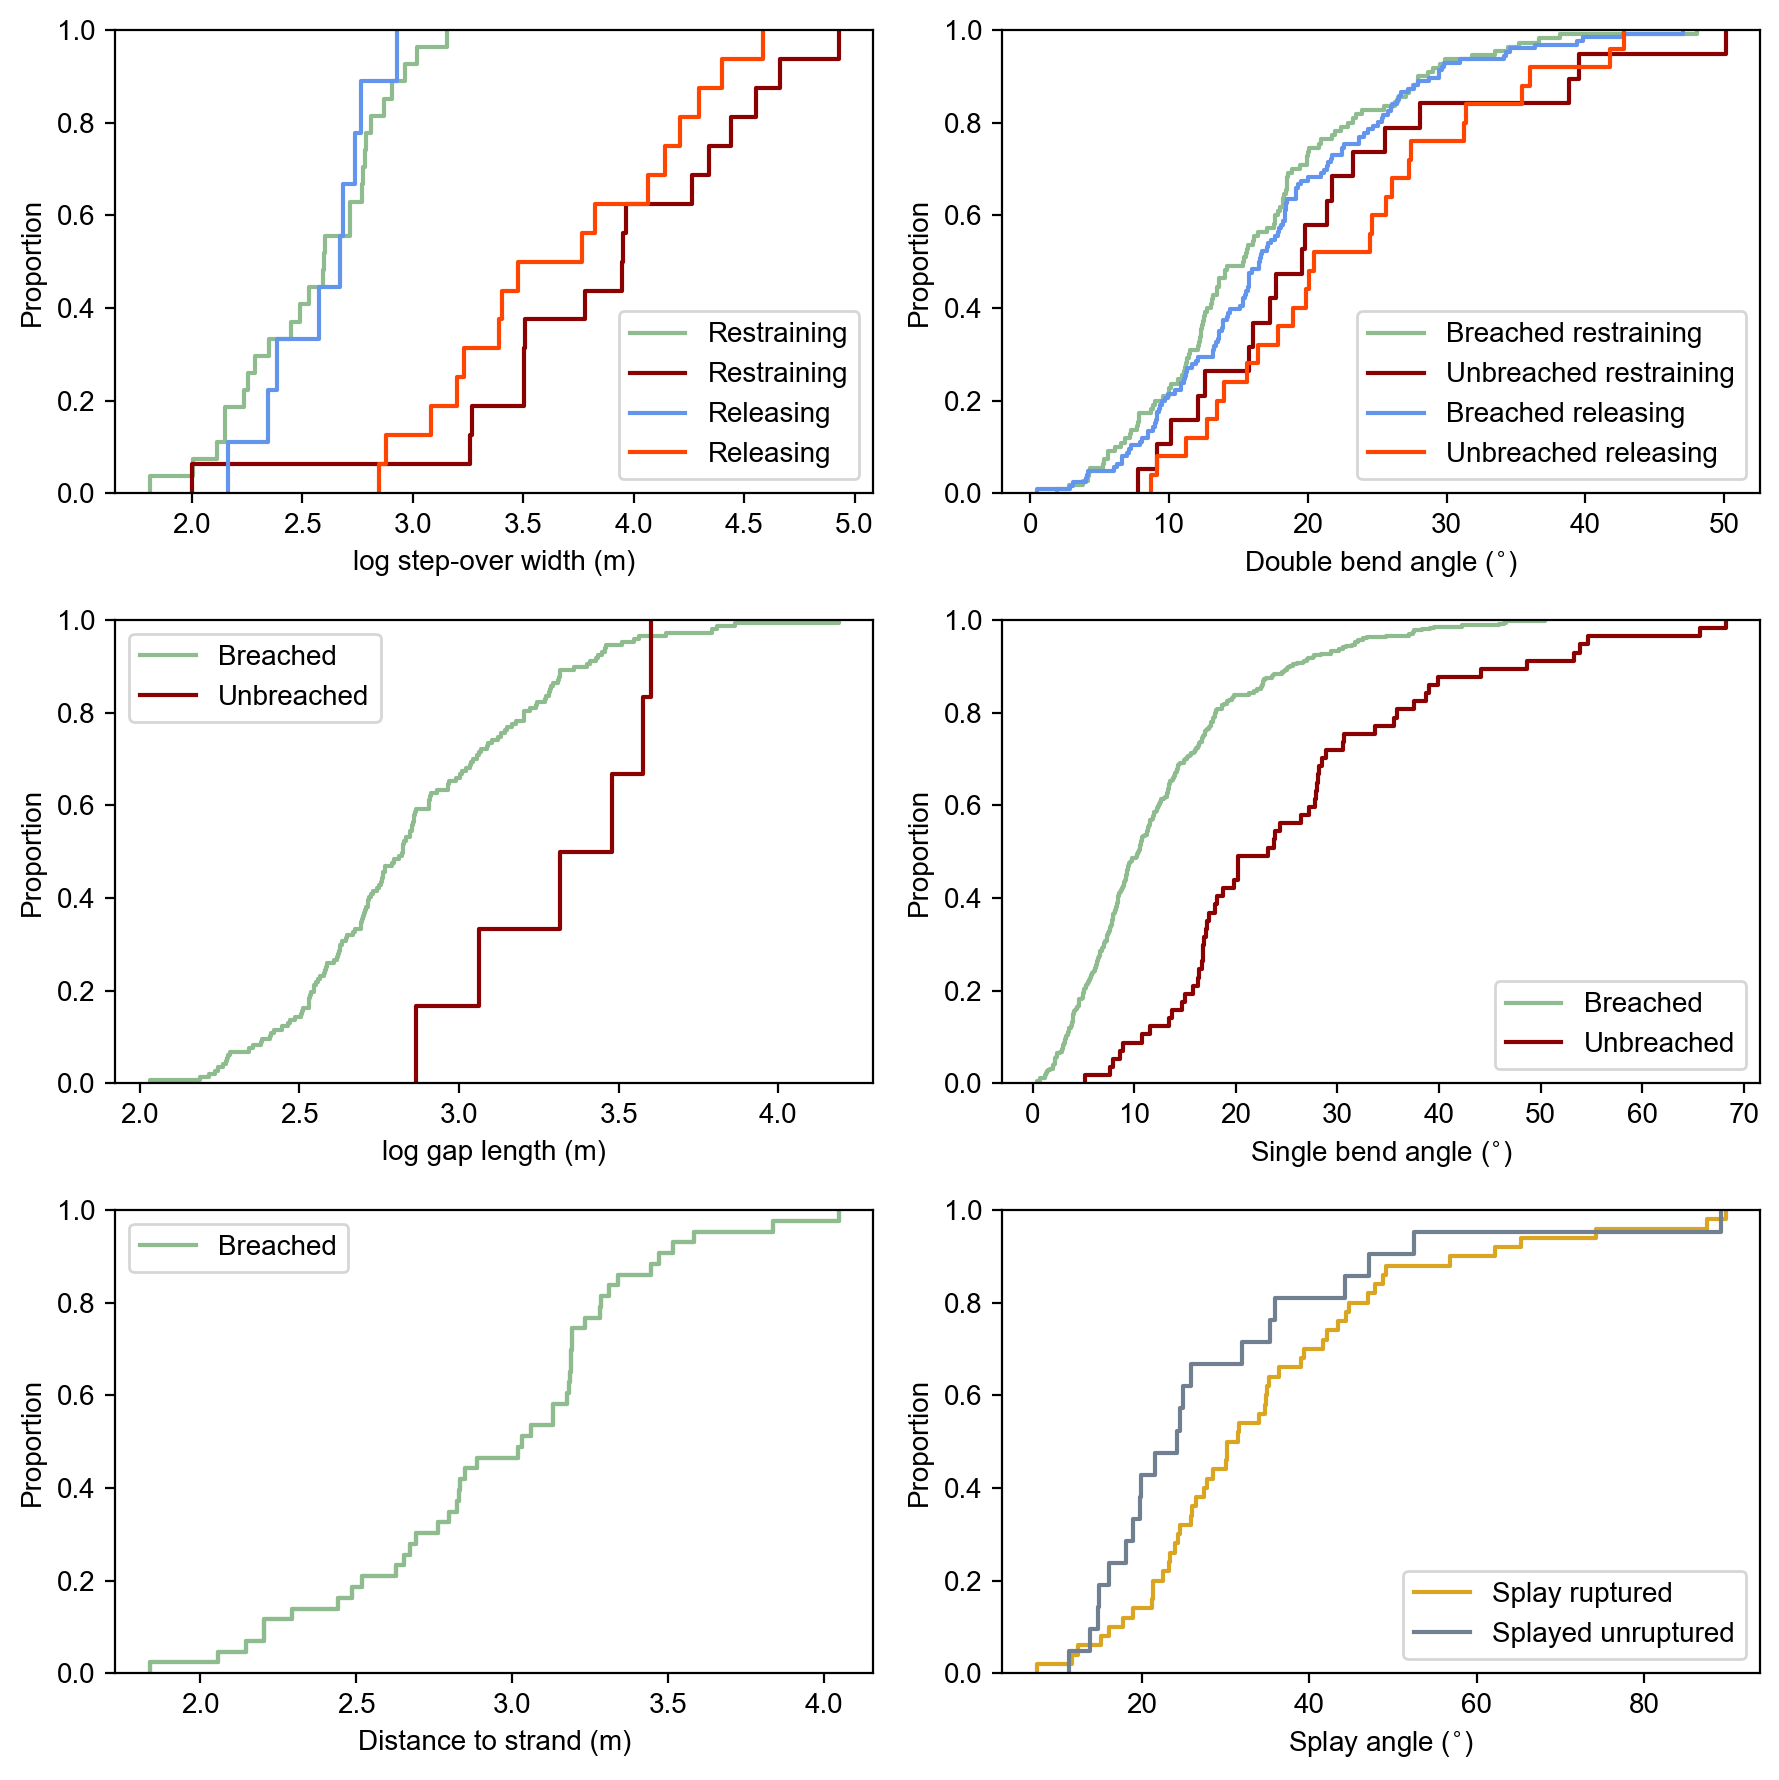

In [57]:
fig, axes = plt.subplots(3,2,figsize=(9,9))

build_cdf('stepover', 'restraining', 'length', 'darkseagreen','darkred',axes[0,0] ,'log step-over width (m)','Restraining', 'Restraining')
build_cdf('stepover', 'releasing', 'length', 'cornflowerblue','orangered',axes[0,0] , 'log step-over width (m)','Releasing', 'Releasing')
build_cdf('bend', 'restraining', 'angle','darkseagreen','darkred',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached restraining', 'Unbreached restraining')
build_cdf('bend', 'releasing', 'angle', 'cornflowerblue','orangered',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached releasing', 'Unbreached releasing')
build_cdf('gap', 'none', 'length', 'darkseagreen','darkred',axes[1,0] , 'log gap length (m)','Breached', 'Unbreached')
build_cdf('bend', 'single', 'angle', 'darkseagreen','darkred',axes[1,1] ,'Single bend angle ($^{\circ}$)','Breached', 'Unbreached')
build_cdf('splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($^{\circ}$)','Splay ruptured', 'Splayed unruptured')
build_cdf('strand', 'none', 'length', 'darkseagreen','darkseagreen',axes[2,0] ,'Distance to strand (m)','Breached', '')
plt.tight_layout()
plt.savefig('GRL/CDFs.pdf')
plt.show()



log-normal distribution fitting

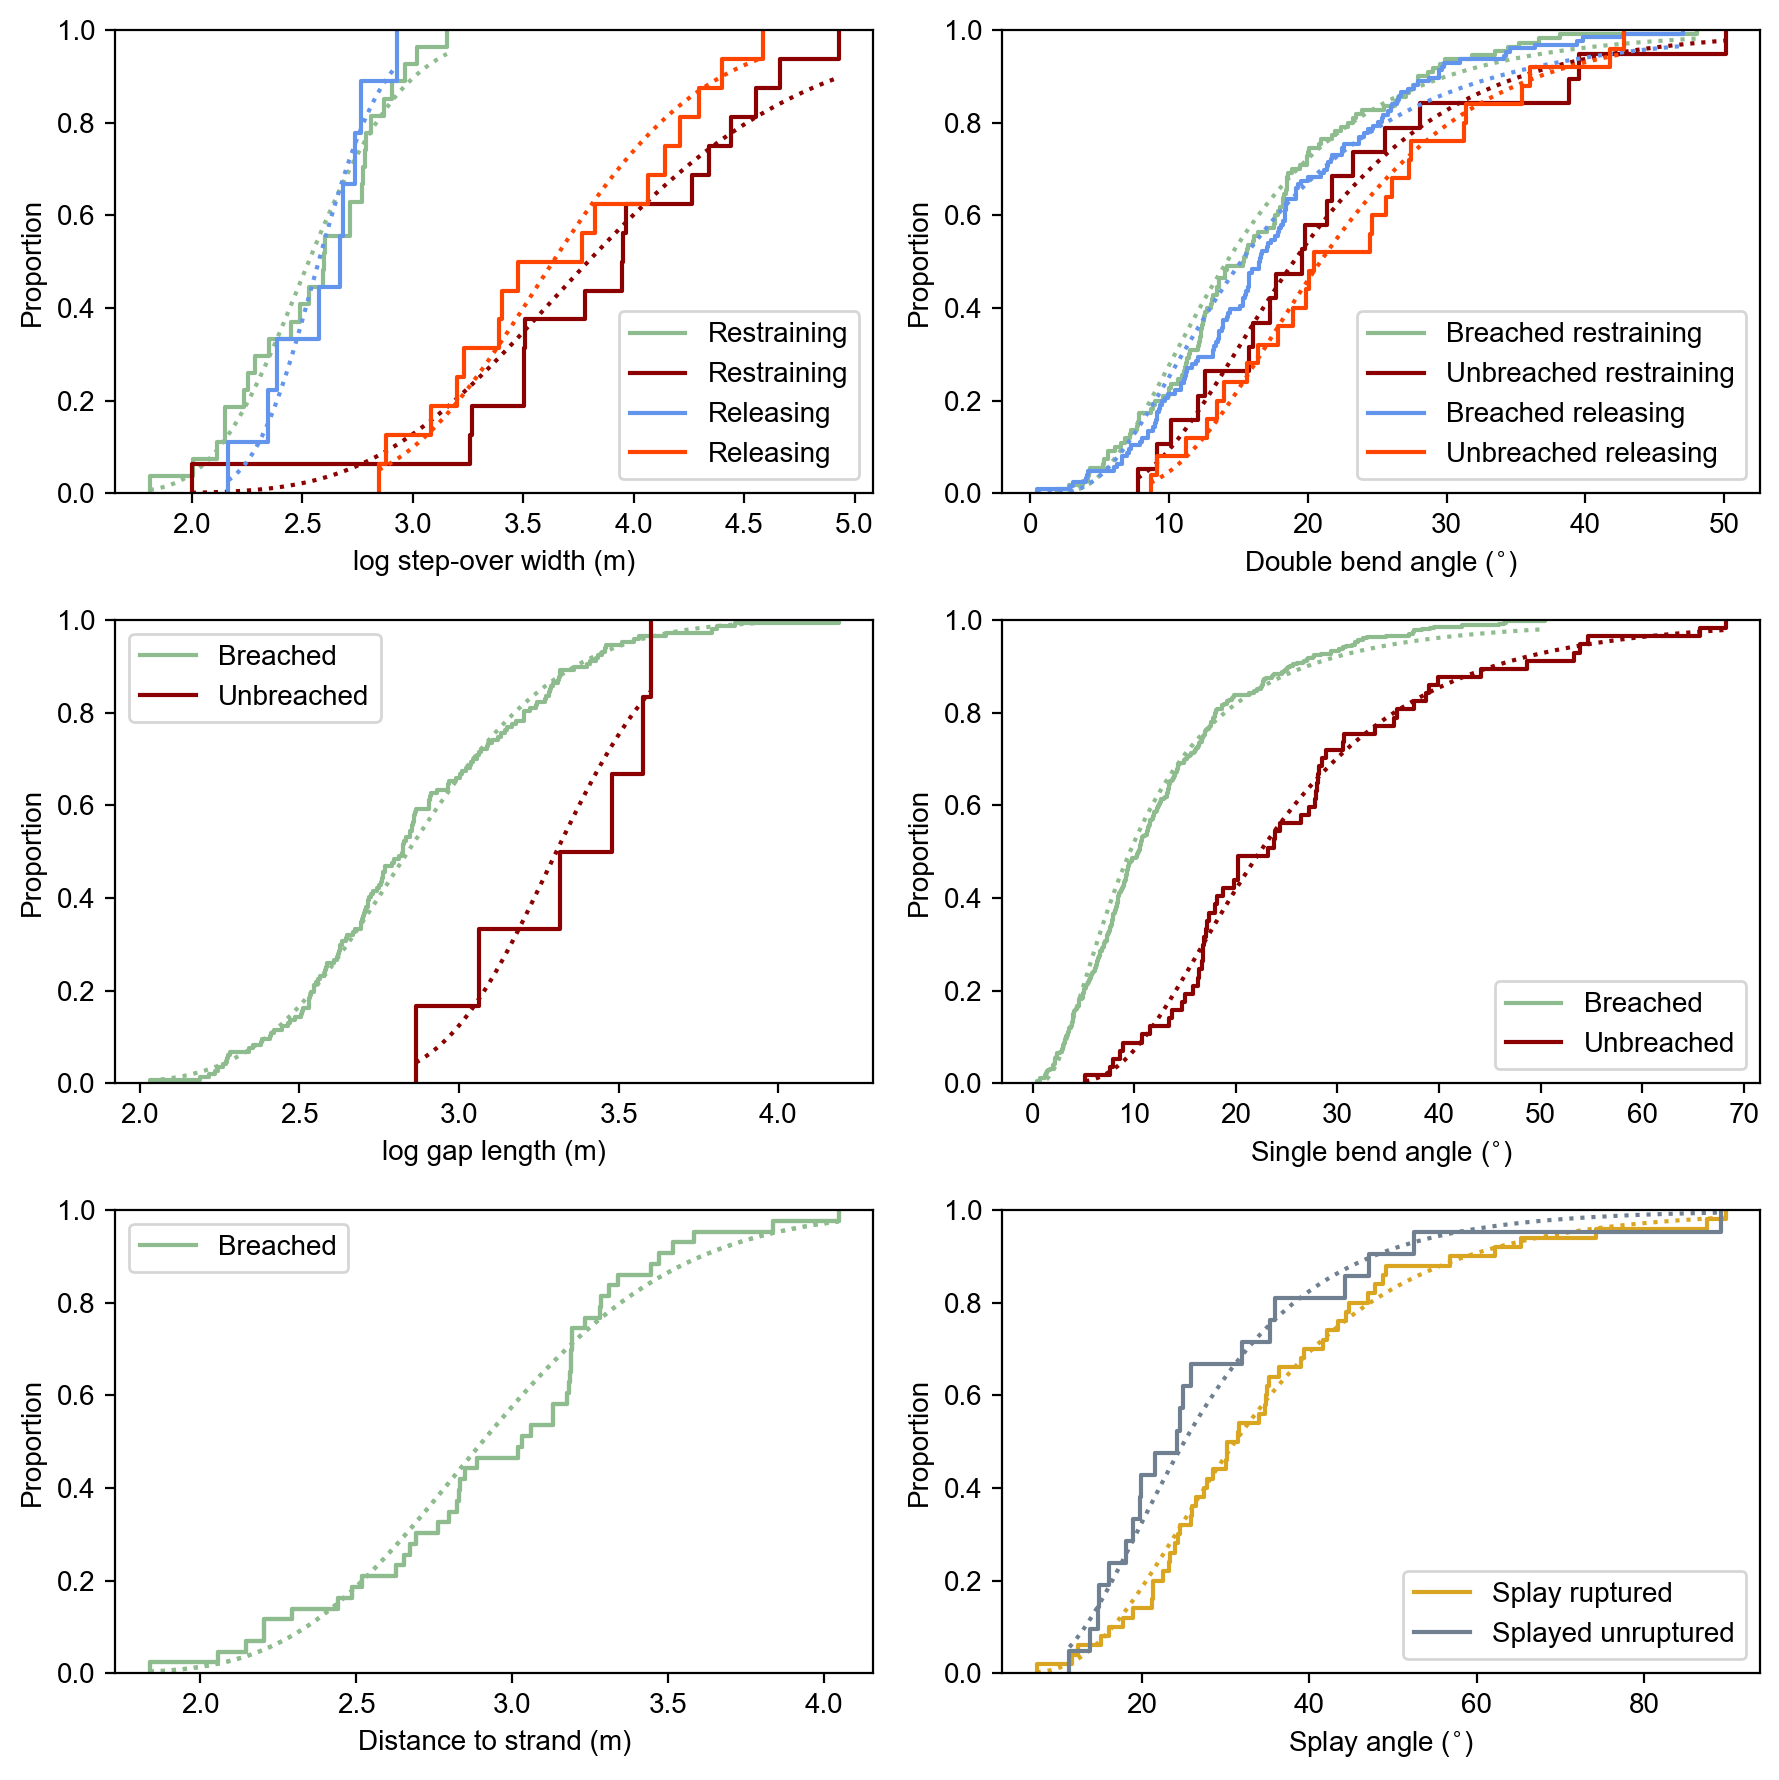

In [58]:
fig, axes = plt.subplots(3,2,figsize=(9,9))

build_cdf_lognorm('stepover', 'restraining', 'length', 'darkseagreen','darkred',axes[0,0] ,'log step-over width (m)','Restraining', 'Restraining')
build_cdf_lognorm('stepover', 'releasing', 'length', 'cornflowerblue','orangered',axes[0,0] , 'log step-over width (m)','Releasing', 'Releasing')
build_cdf_lognorm('bend', 'restraining', 'angle','darkseagreen','darkred',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached restraining', 'Unbreached restraining')
build_cdf_lognorm('bend', 'releasing', 'angle', 'cornflowerblue','orangered',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached releasing', 'Unbreached releasing')
build_cdf_lognorm('gap', 'none', 'length', 'darkseagreen','darkred',axes[1,0] , 'log gap length (m)','Breached', 'Unbreached')
build_cdf_lognorm('bend', 'single', 'angle', 'darkseagreen','darkred',axes[1,1] ,'Single bend angle ($^{\circ}$)','Breached', 'Unbreached')
build_cdf_lognorm('splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($^{\circ}$)','Splay ruptured', 'Splayed unruptured')
build_cdf_lognorm('strand', 'none', 'length', 'darkseagreen','darkseagreen',axes[2,0] ,'Distance to strand (m)','Breached', '')
plt.tight_layout()
plt.savefig('GRL/lognorm_CDFs.pdf')
plt.show()



PDFs

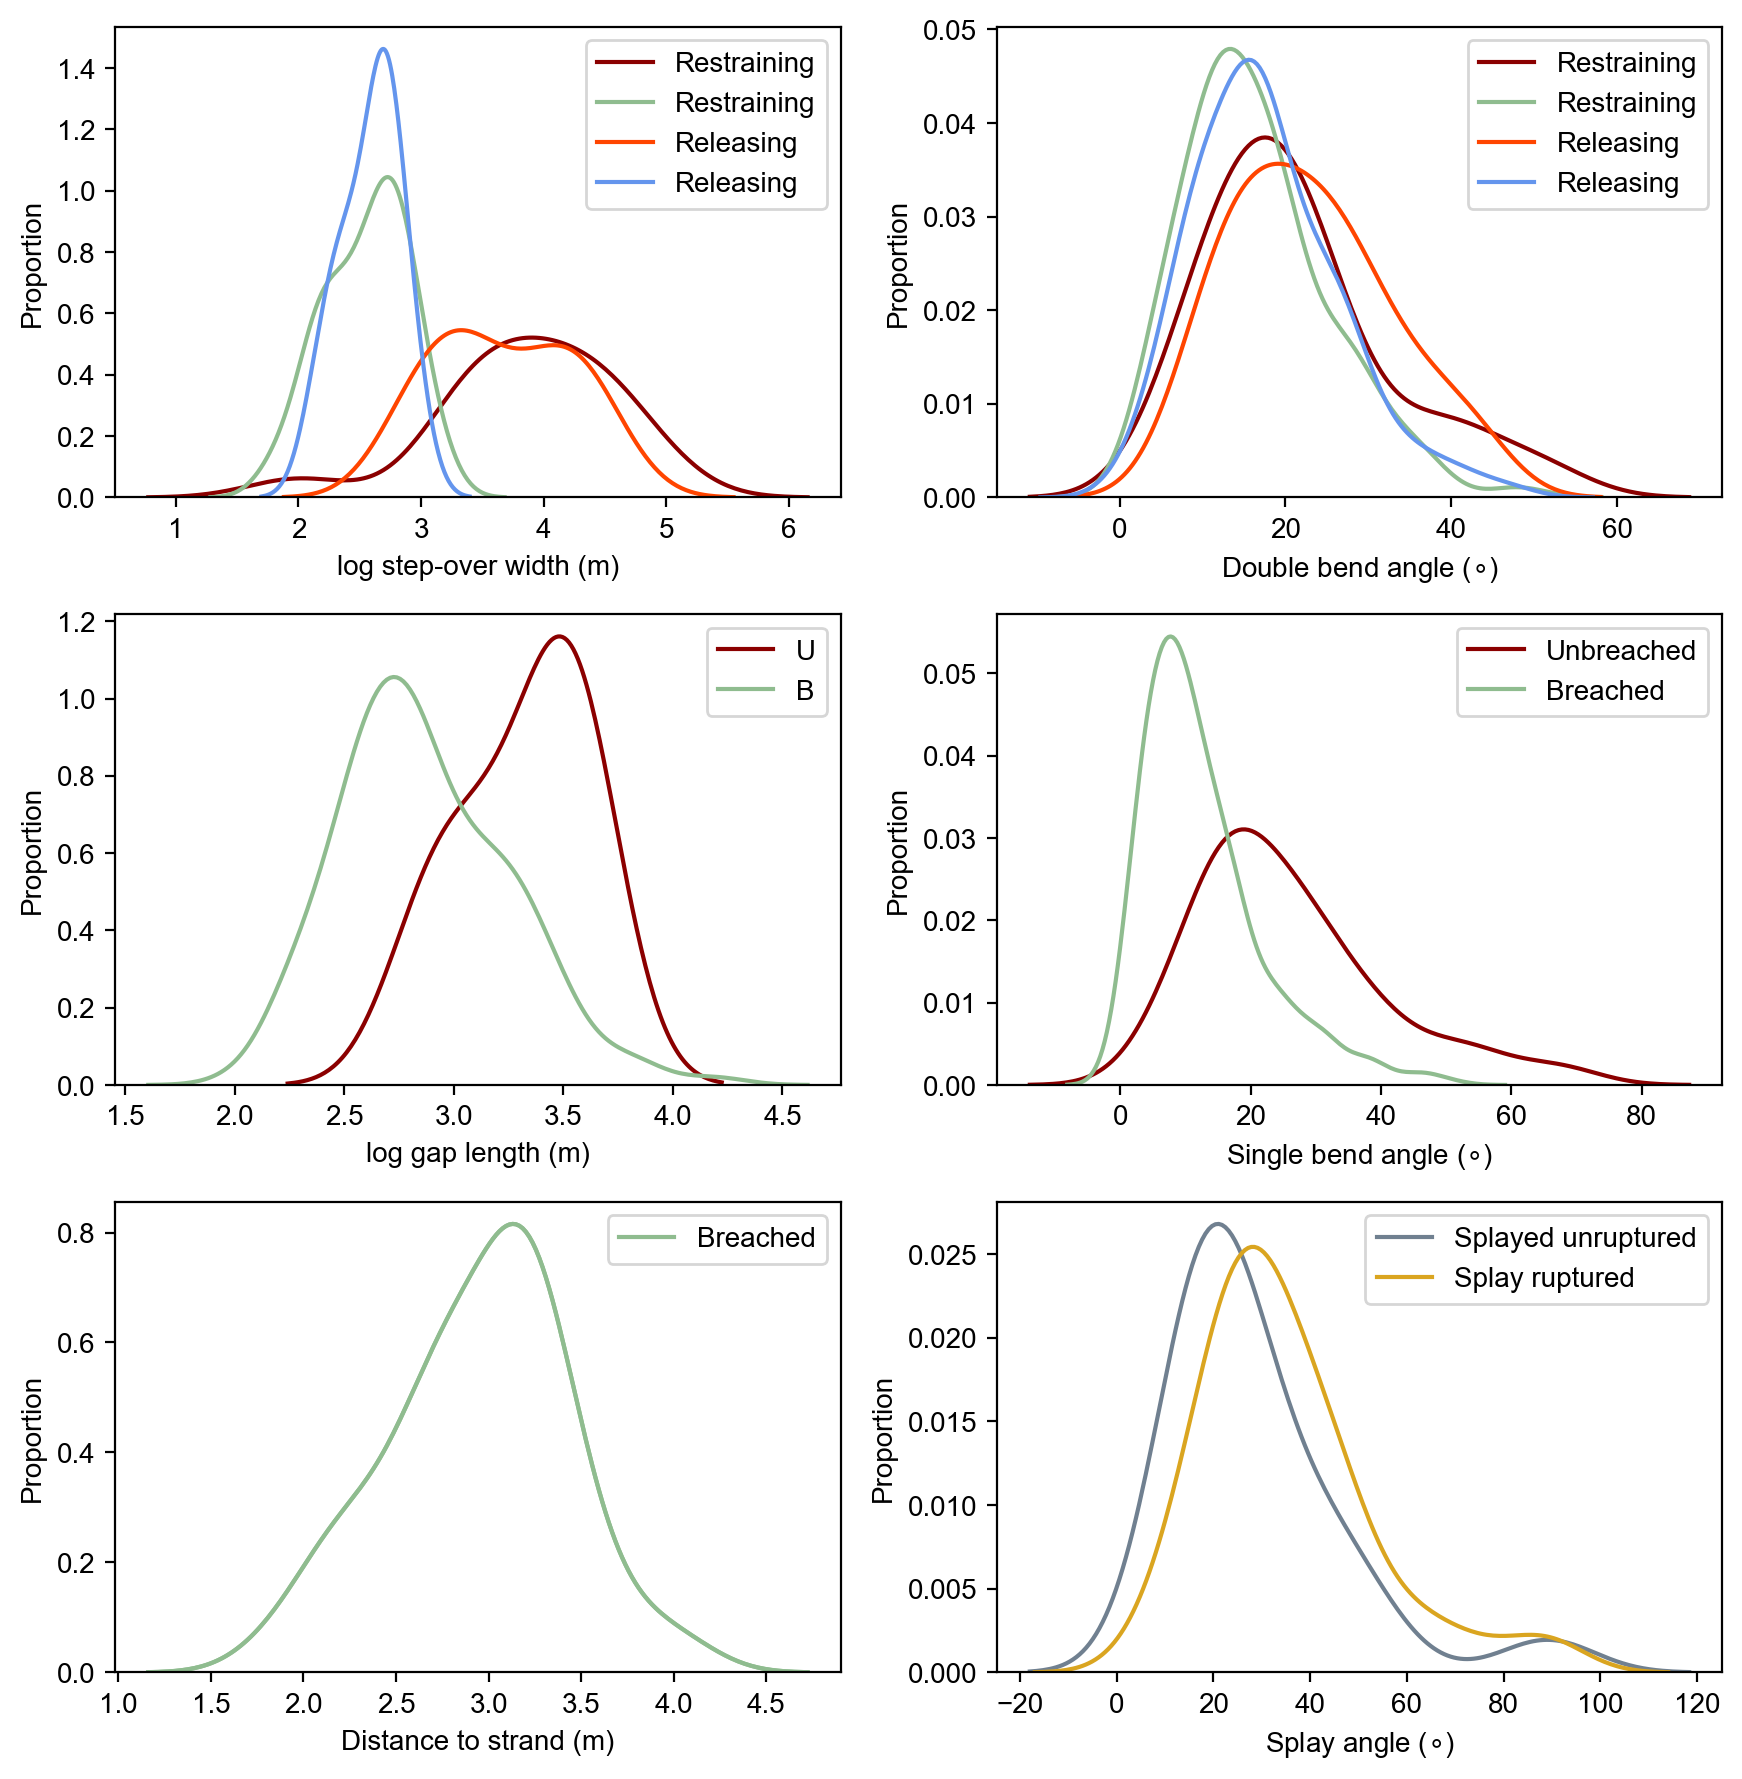

In [59]:
fig, axes = plt.subplots(3,2,figsize=(9,9))

build_pdf('stepover', 'restraining', 'length', 'darkseagreen','darkred',axes[0,0] ,'log step-over width (m)','Restraining', 'Restraining')
build_pdf('stepover', 'releasing', 'length', 'cornflowerblue','orangered',axes[0,0] , 'log step-over width (m)','Releasing', 'Releasing')
build_pdf('bend', 'restraining', 'angle','darkseagreen','darkred',axes[0,1] ,'Double bend angle ($\circ$)','Restraining', 'Restraining')
build_pdf('bend', 'releasing', 'angle', 'cornflowerblue','orangered',axes[0,1] ,'Double bend angle ($\circ$)','Releasing', 'Releasing')
build_pdf('gap', 'none', 'length', 'darkseagreen','darkred',axes[1,0] , 'log gap length (m)','B', 'U')
build_pdf('bend', 'single', 'angle', 'darkseagreen','darkred',axes[1,1] ,'Single bend angle ($\circ$)','Breached', 'Unbreached')
build_pdf('splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($\circ$)','Splay ruptured', 'Splayed unruptured')
build_pdf('strand', 'none', 'length', 'darkseagreen','darkseagreen',axes[2,0] ,'Distance to strand (m)','Breached', '')
plt.tight_layout()
plt.savefig('GRL/PDFs.pdf')
plt.show()



ks tests

In [60]:
# ks test for populations of earthquake gates
double_bend_ks = kstest_variables('bend', 'double', 'angle')
print(double_bend_ks)

single_bend_ks = kstest_variables('bend', 'single', 'angle')
print(single_bend_ks)

stepover_ks_releasing = kstest_variables('stepover', 'none', 'length')
print(stepover_ks_releasing)

stepover_ks_restraining = kstest_variables('stepover', 'restraining', 'length')
print(stepover_ks_restraining)

gap_ks = kstest_variables('gap', '', 'length')
print(gap_ks)

splay_ks = kstest_variables('splay', 'none', 'angle')
print(splay_ks)

releasing_restraining_unbreached_bend_ks = kstest_variables('bend', 'releasing_restraining_unbreached', 'angle')
print(releasing_restraining_unbreached_bend_ks)

releasing_restraining_breached_bend_ks = kstest_variables('bend', 'releasing_restraining_breached', 'angle')
print(releasing_restraining_breached_bend_ks)

releasing_restraining_breached_stepover_ks = kstest_variables('stepover', 'releasing_restraining_breached', 'length')
print(releasing_restraining_breached_stepover_ks)

releasing_restraining_unbreached_stepover_ks = kstest_variables('stepover', 'releasing_restraining_unbreached', 'length')
print(releasing_restraining_unbreached_stepover_ks)

KstestResult(statistic=0.25082206795761786, pvalue=0.012557095293868016, statistic_location=18.5763718668092, statistic_sign=1)
KstestResult(statistic=0.5341956586381207, pvalue=1.6896184827274396e-13, statistic_location=14.5420634348074, statistic_sign=1)
KstestResult(statistic=0.8784722222222222, pvalue=5.85136471753042e-14, statistic_location=3.0186515385142907, statistic_sign=1)
KstestResult(statistic=0.9375, pvalue=3.243053887812841e-10, statistic_location=3.154597451947373, statistic_sign=1)
KstestResult(statistic=0.5918367346938775, pvalue=0.01937621906188794, statistic_location=2.8652469727228658, statistic_sign=1)
KstestResult(statistic=0.32666666666666666, pvalue=0.06517251106377434, statistic_location=25.8837228358785, statistic_sign=-1)
KstestResult(statistic=0.2168421052631579, pvalue=0.6028707087055148, statistic_location=23.2310156499948, statistic_sign=-1)
KstestResult(statistic=0.12568542568542568, pvalue=0.2796730961611222, statistic_location=13.1605244124259, statist

# Plot passing probabilities and earthquake gate analysis

Logistic models

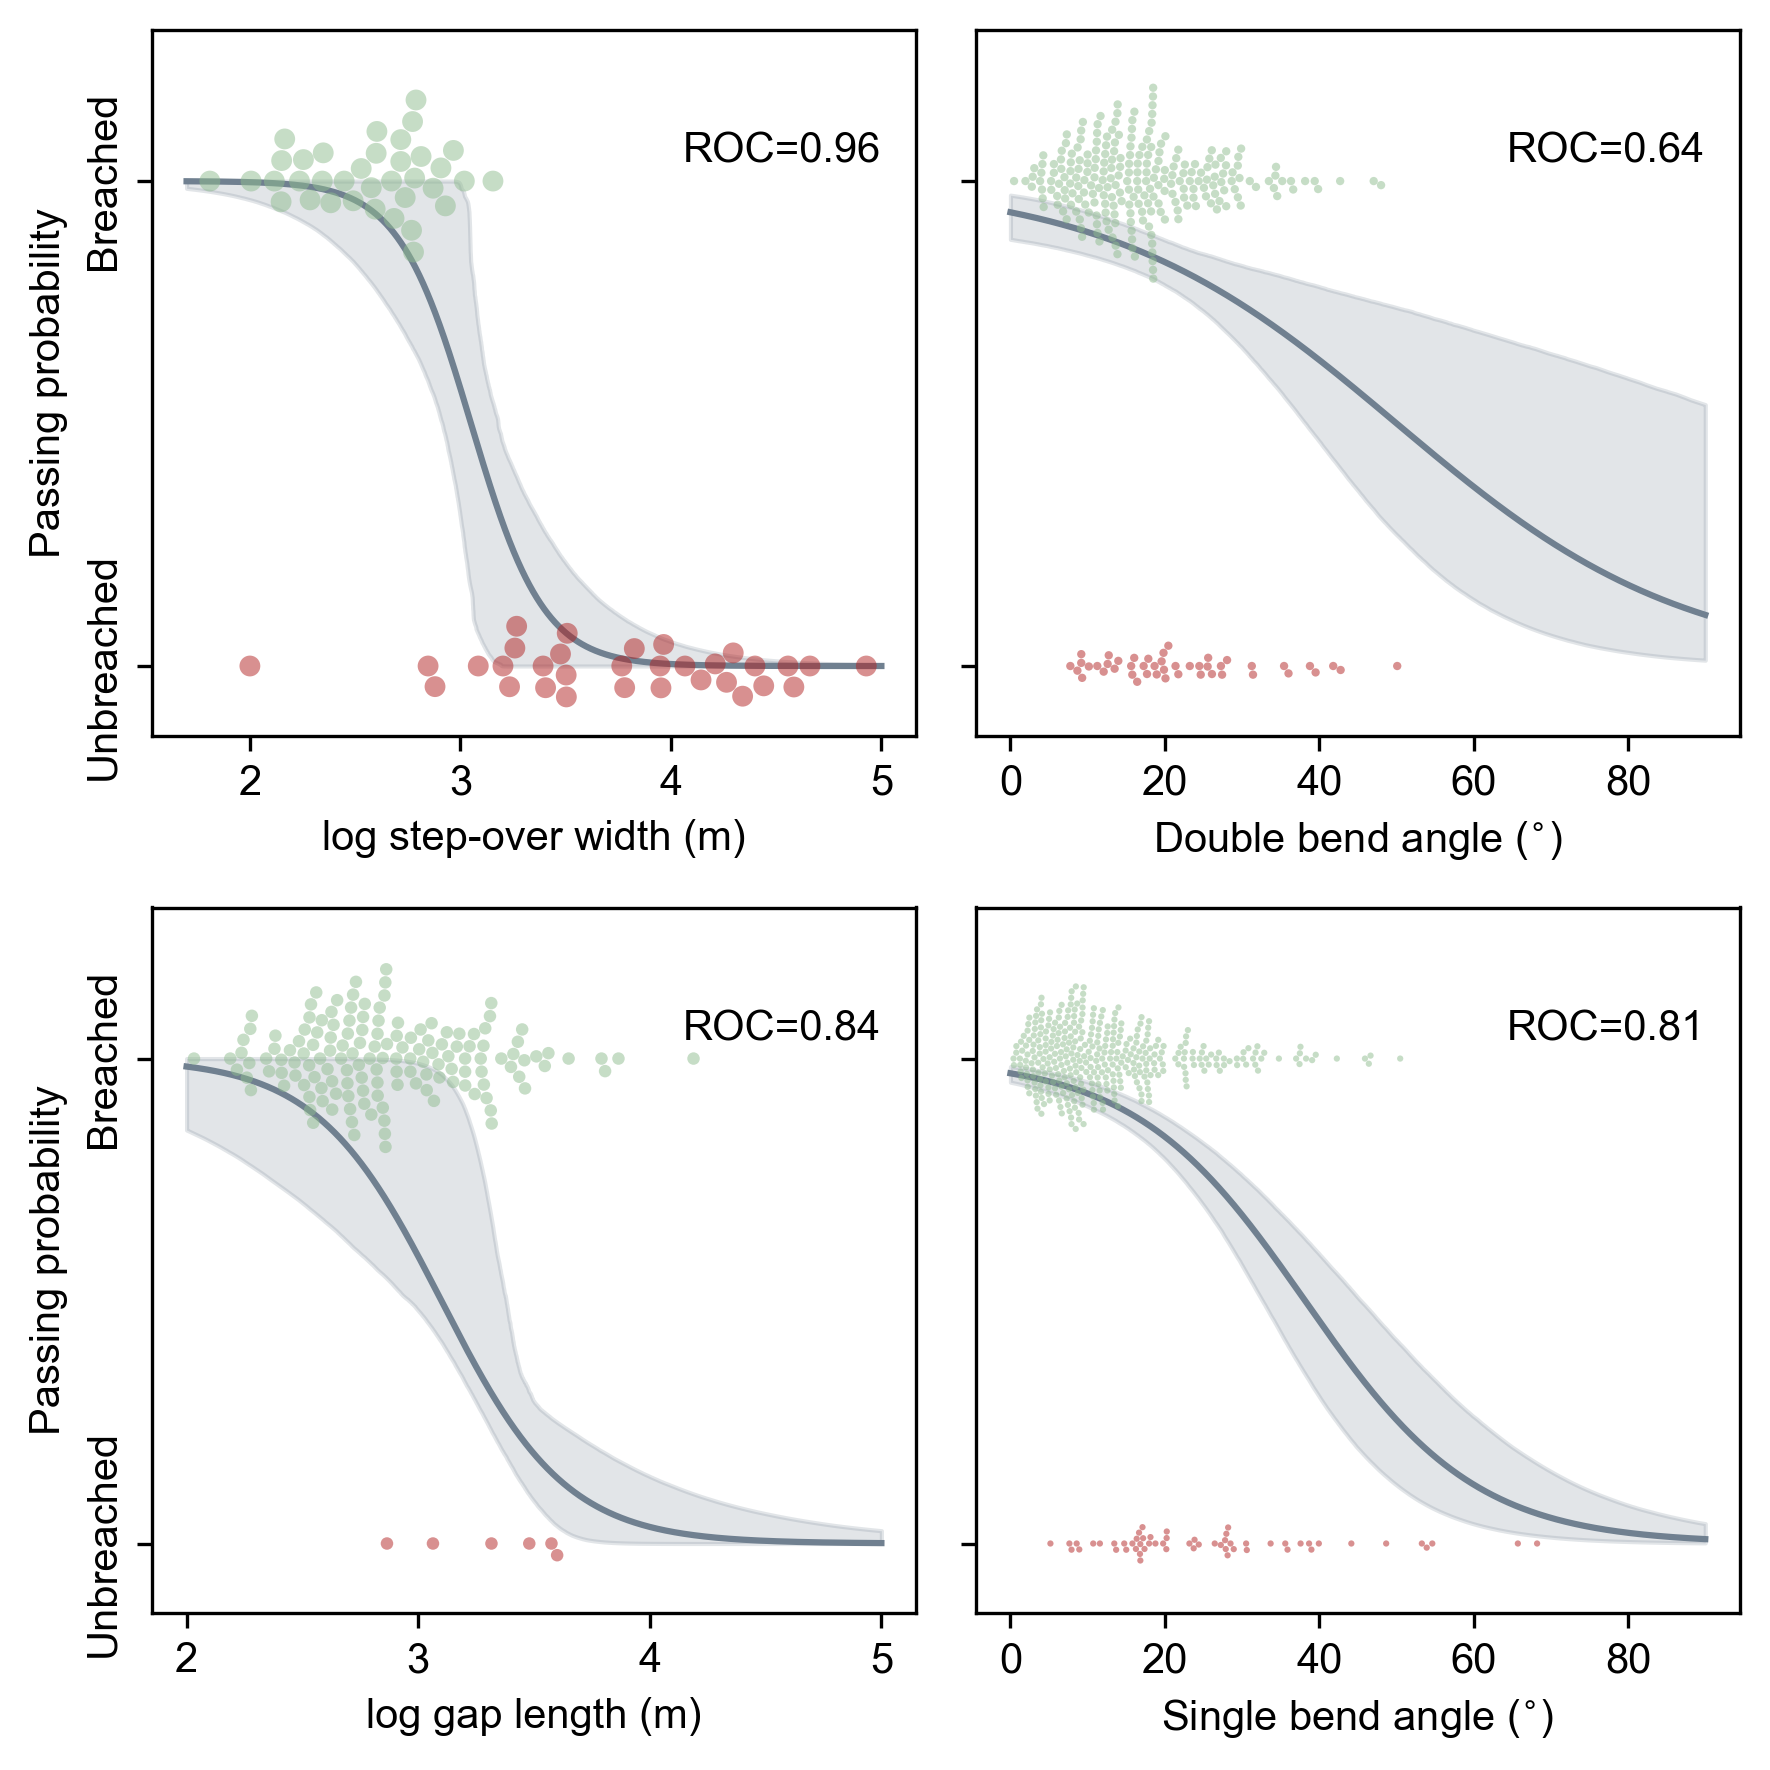

In [61]:
fig, axes = plt.subplots(2,2,figsize=(6,6), sharey=True, dpi=300)
 
log_stepover, acc_stepover, pre_stepover, f1_stepover, roc_stepover, confusion_matrix_stepover, BUbin_stepover,xstepover = build_regression(
    'stepover', 
    'none', 
    'length', 
    None, 
    False, 
    {"color": "white", "alpha": 0.0001,"linewidth":0.0001}, 
    {"color": "lightgrey","edgecolors":None},
    axes[0,0],
    50,
    100000,
    'slategrey',
    'log step-over width (m)',
    5
)

#log_stepover_releasing = build_regression('stepover', 'releasing', 'length', 'balanced', False, {"color": "white", "alpha": 0.0001,"linewidth":0.0001}, {"color": "goldenrod"},'releasing',axes[0],100,100000,'goldenrod','log step-over width (m)')
log_bend_double, acc_bend_double, pre_bend_double, f1_bend_double, roc_bend_double, confusion_matrix_bend_double,BUbin_bend_double,xbenddouble= build_regression('bend', 'double', 'angle', None, False, {"color": "white", "alpha": 0.0001,"linewidth":0.0001}, 
                                                                                                                                                                 {"color": "lightgrey","alpha":0.5,"edgecolors":None},axes[0,1],0,90,'slategrey','Double bend angle ($^{\circ}$)',2)
#log_bend_releasing = build_regression('bend', 'releasing', 'angle', False, False, {"color": "white", "alpha": 0.0001,"linewidth":0.0001}, {"color": "goldenrod"},'releasing',axes[2],0,90,'goldenrod','Double bend angle ($\circ$)')
log_bend_single, acc_bend_single, pre_bend_single, f1_bend_single, roc_bend_single, confusion_matrix_bend_single,BUbin_bend_single,xbendsingle = build_regression('bend', 'single', 'angle', None, False, {"color": "white", "alpha": 0.0001,"linewidth":0.0001},
                                                                                                                                                                   {"color": "lightgrey","alpha":0.5,"edgecolors":None},axes[1,1],0,90,'slategrey','Single bend angle ($^{\circ}$)',1.5)

log_gap, acc_gap, pre_gap, f1_gap, roc_gap, confusion_matrix_gap, BUbin_gap,xgap = build_regression('gap', 'none', 'length', 'balanced', False, {"color": "white", "alpha": 0.0001,"linewidth":0.0001}, {"color": "lightgrey","edgecolors":None},axes[1,0],100,100000,'slategrey','log gap length (m)',3)


#[iax.set(ylabel=None) for iax in axes[0]]
#[iax.set_yticklabels(['Breached','Unbreached'],rotation=90,va='center') for iax in axes[:,1]]


plt.tight_layout()
plt.savefig('GRL/PP_EQgates.pdf')
plt.show()

Predict probability for earthquake gate of given geometry based on logistic model for that type of earthquake gate

In [62]:
#x = np.atleast_2d(25).T
x = np.atleast_2d(np.log10(2000)).T
proba = log_stepover.predict_proba(x)[:,0]
proba

array([0.18961847])

Let's assess the quality of the logistic regressions. 

In [63]:
print("ROC step-over",roc_stepover)
print("ROC single bend",roc_bend_single)
print("ROC double bend",roc_bend_double)
print("ROC gap",roc_gap)

ROC step-over 0.9592013888888888
ROC single bend 0.8109822579046486
ROC double bend 0.6417610522469858
ROC gap 0.844671201814059


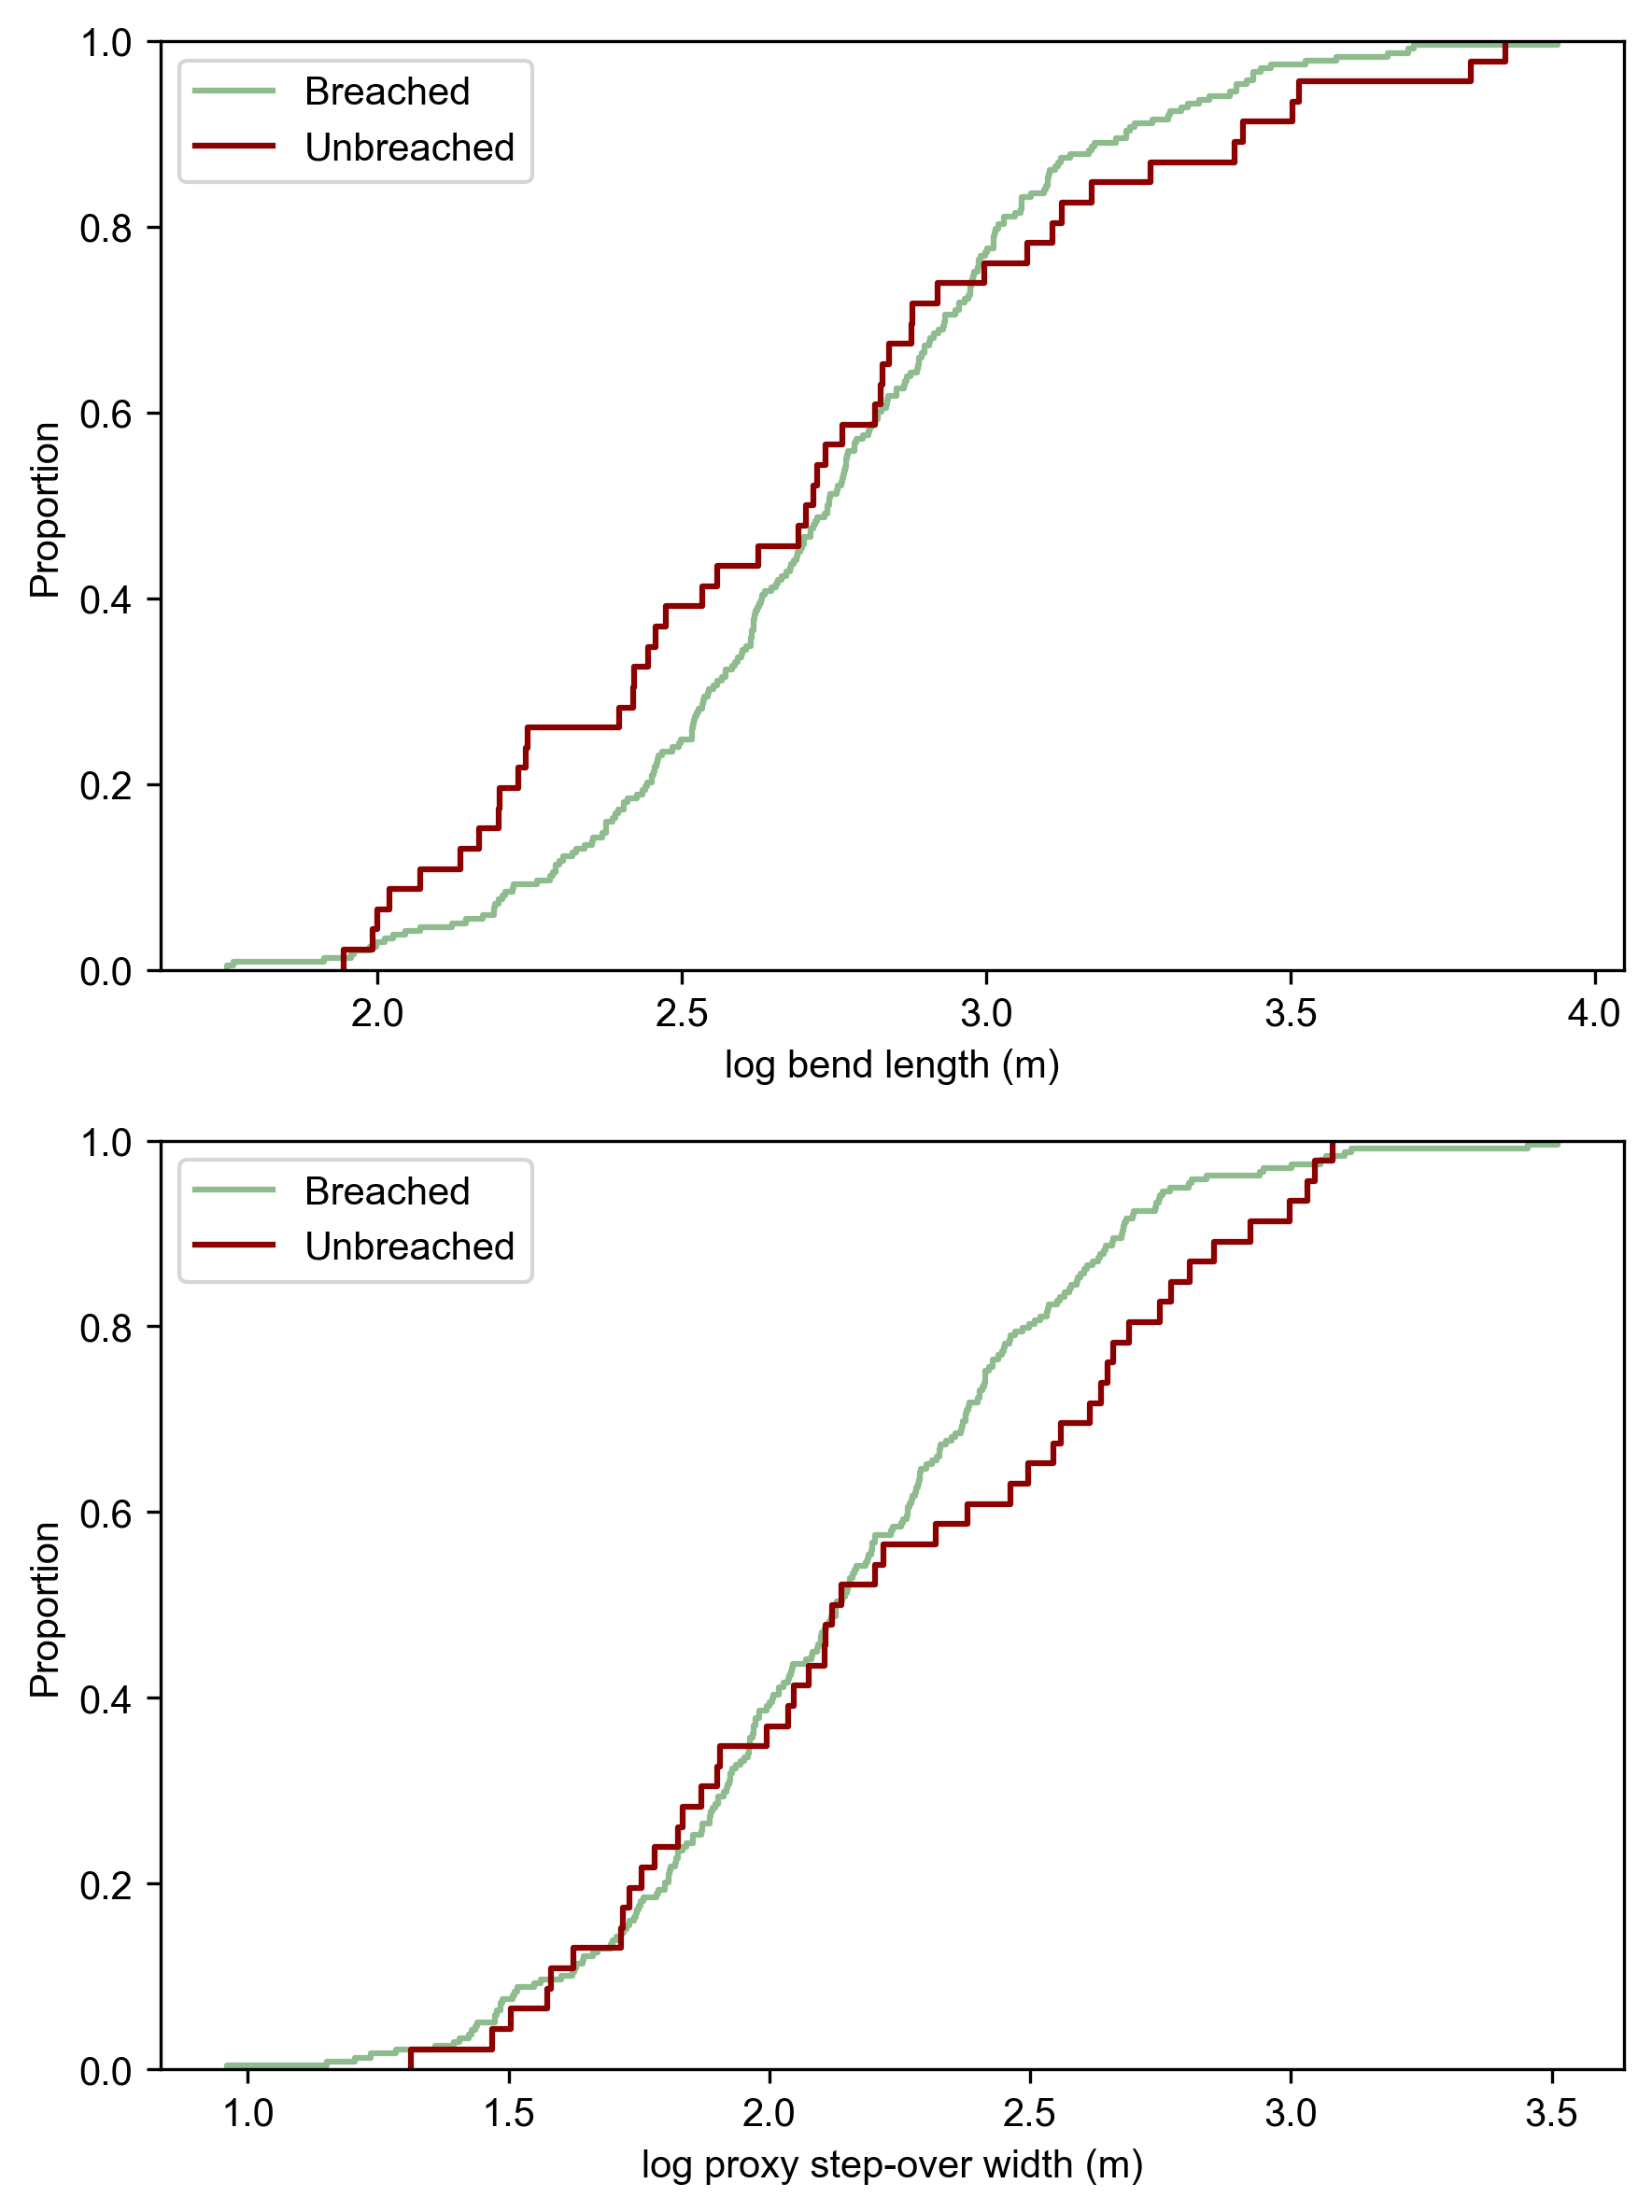

In [64]:
fig, ax = plt.subplots(2,1,figsize=(6,8), dpi=300)
build_cdf_bend_lengths('bend', 'double', 'Distance splay or double bend (m)', 'darkseagreen','darkred',ax[0],'log bend length (m)','Breached', 'Unbreached')
build_cdf_bend_lengths('bend', 'double', 'Spacing double bend (m)', 'darkseagreen','darkred',ax[1],'log proxy step-over width (m)','Breached', 'Unbreached')
plt.tight_layout()
plt.savefig('GRL/bend_length_CDFs.pdf')

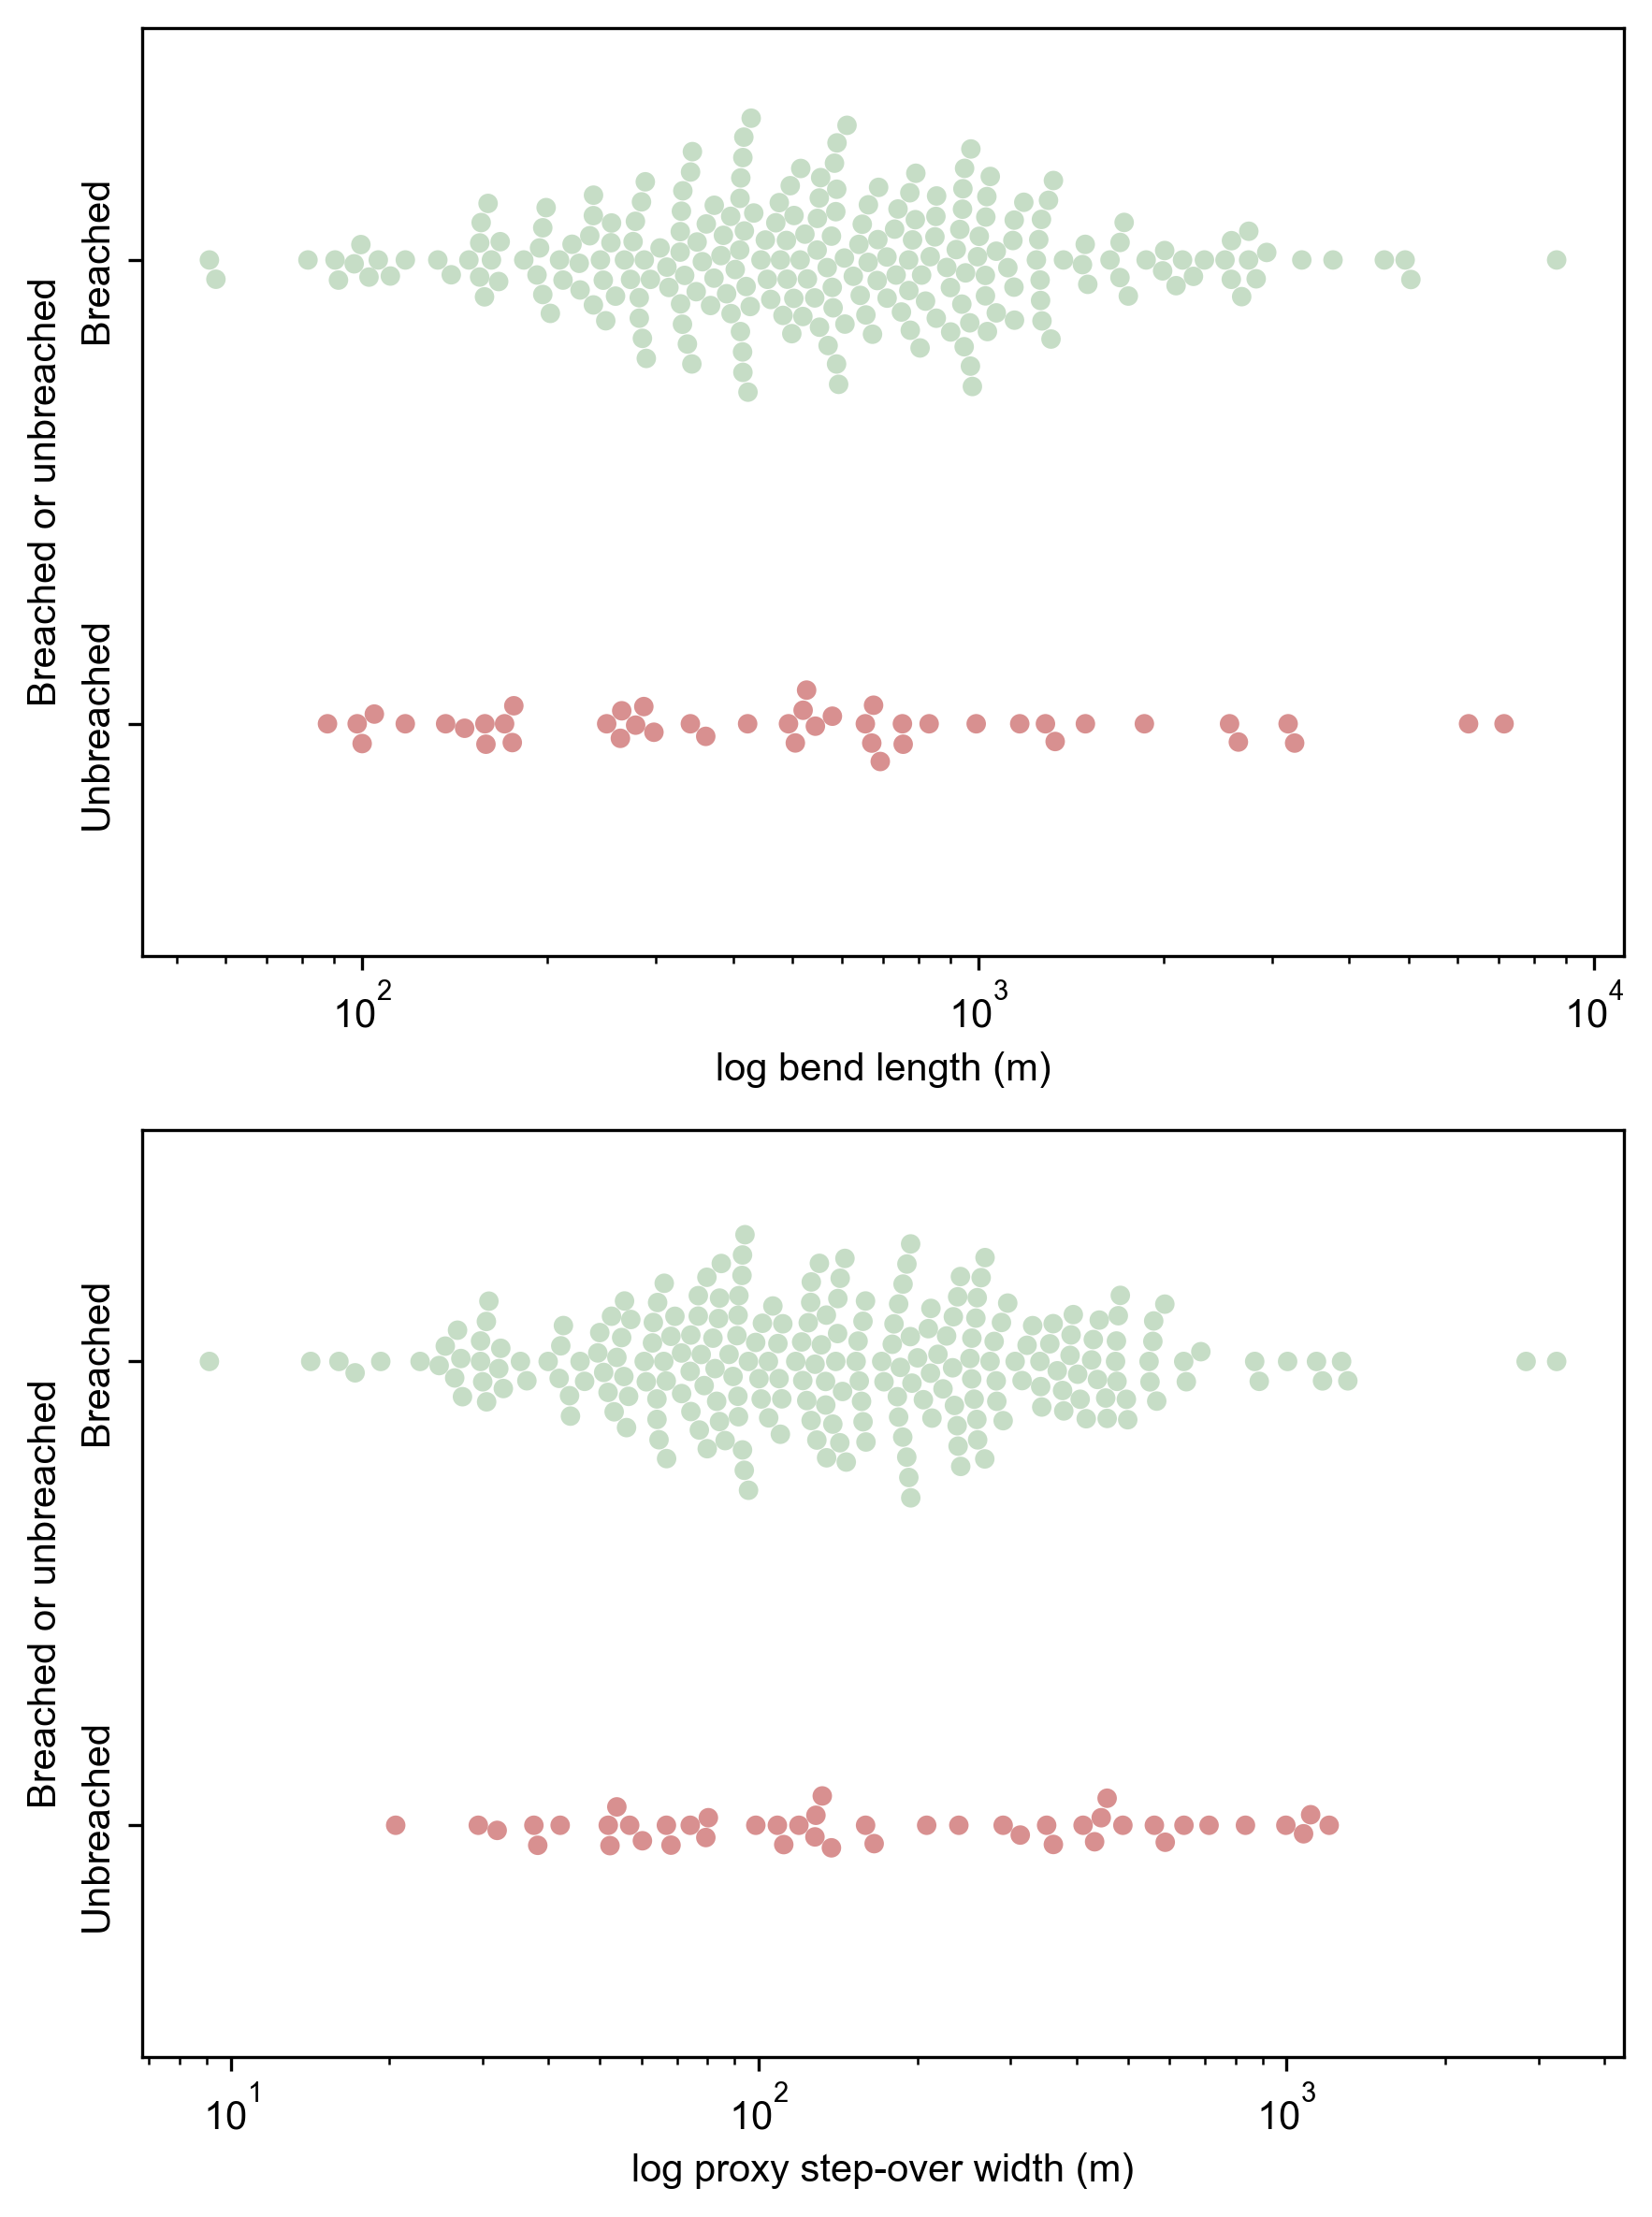

In [65]:
fig, ax = plt.subplots(2,1,figsize=(6,8), dpi=300)
build_regression_double_bend_length('bend', 'double', 'Distance splay or double bend (m)',ax[0],1,4000,'slategrey','log bend length (m)',5,None)
build_regression_double_bend_length('bend', 'double', 'Spacing double bend (m)',ax[1],1,4000,'slategrey','log proxy step-over width (m)',5,None)
plt.tight_layout()
plt.savefig('GRL/bend_lengths.pdf.pdf')

Confusion matrices to evaluate logistic model fit

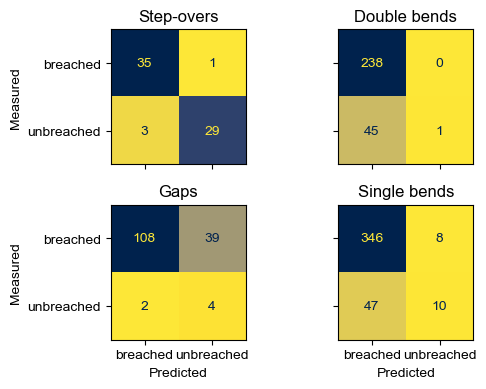

In [66]:
fig, axes = plt.subplots(2,2,figsize=(6,4), dpi=100,sharex=True,sharey=True)
# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('cividis')
labels = ['breached', 'unbreached']
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

disp_stepover = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_stepover,display_labels=labels)
disp_stepover.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[0,0])
axes[0,0].set_title('Step-overs')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Measured')

disp_double_bend = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bend_double,display_labels=labels)
disp_double_bend.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[0,1])
axes[0,1].set_title('Double bends')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')

disp_double_single = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bend_single,display_labels=labels)
disp_double_single.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[1,1])
axes[1,1].set_title('Single bends')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('')

disp_gap = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_gap,display_labels=labels)
disp_gap.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[1,0])
axes[1,0].set_title('Gaps')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Measured')

plt.tight_layout()
plt.savefig('GRL/confusion_matrices.pdf')
plt.show()


ks tests:

In [67]:
# ks test for determining whether populations are different (statistically)
double_bend_ks = kstest_variables('bend', 'single', 'angle')
print(double_bend_ks)
splay_ks = kstest_variables('splay', 'none', 'angle')
print(splay_ks)

KstestResult(statistic=0.5341956586381207, pvalue=1.6896184827274396e-13, statistic_location=14.5420634348074, statistic_sign=1)
KstestResult(statistic=0.32666666666666666, pvalue=0.06517251106377434, statistic_location=25.8837228358785, statistic_sign=-1)


Nearest distance between strand and step-over:

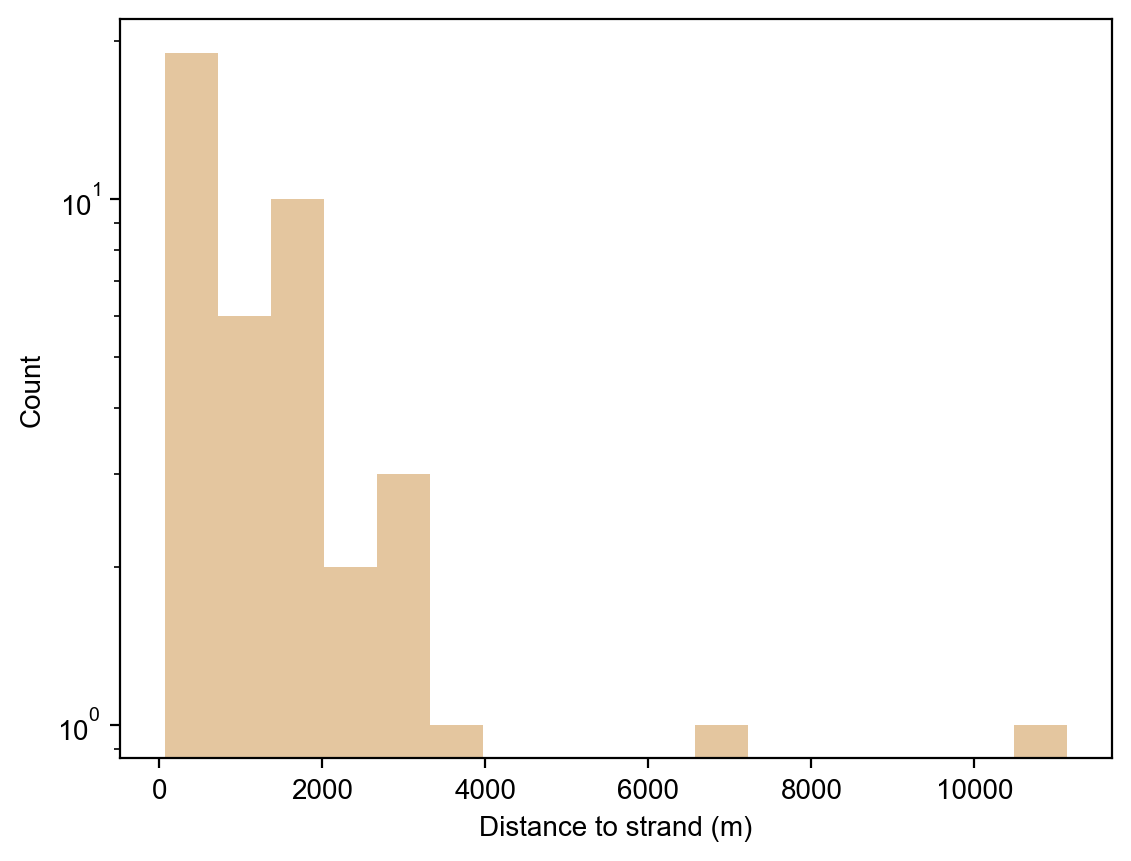

In [68]:
strand = grouped.get_group("strand")

bins = np.histogram_bin_edges(strand, bins=5, range=[1,max(strand['Length (m) or angle (deg)'])], weights=None)

sns.histplot(strand,x='Length (m) or angle (deg)',color='burlywood',edgecolor='none',alpha=0.8,label='Strand')
plt.yscale('log')
plt.xlabel('Distance to strand (m)')
plt.savefig('GRL/strand_RR.pdf')
plt.show() 

# Analysis of earthquake likelihood magnitude dependence

Extract passing probability for all mapped gates based on logistic models:
-- Note gaps, splays (statiscally indifferent), and strands are all assigned probabilities of 1 given the do not influence rupture propagation

In [69]:
fun_dict = {
    'log_stepover' : log_stepover,  # log_stepover_releasing
    'log_bend_single': log_bend_single,
    'log_bend_double':log_bend_double,
    'log_gap': log_gap
}

PR = []

for i in range(len(data)): 
    datai = data.iloc[i]
    featurei = datai['Feature']
    RRi = datai['Type (releasing or restraining)']

    if featurei == 'bend':
        RRi = datai['Type (releasing or restraining)']
        RRstr = str(RRi)
        
        if RRstr == 'nan':
            name_select = 'log' + '_' + 'bend' + '_' + 'single'
            extract = fun_dict[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

        else:
            name_select = 'log' + '_' + 'bend' + '_' + 'double'
            extract = fun_dict[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

    # elif featurei == 'gap':
    #     strlog = 'log'
    #     name_select = strlog + '_' + 'gap' 
    #     extract = fun_dict[name_select]
    #     x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
    #     PRi  = extract.predict_proba(np.log10(x))[:,0]

    elif featurei == 'stepover': 
        featurestr = str(featurei)
        strlog = 'log'
        RRstr = str(RRi)
        name_select = strlog + '_' + featurestr 
        extract = fun_dict[name_select]
        x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
        PRi  = extract.predict_proba(np.log10(x))[:,0]
    
    else:
        PRi = 1
        

    # PRi = [:, 1]
    PR.append(PRi)

data['PR'] = PR


Calculate earthquake likelihood for each event based on the previously estimated probabilities for each earthquake gate

In [70]:
event = data["Earthquake"]
event.unique()

mag = np.array([])
event_likelihood = np.array([])
event_group = event.unique()
cumdisp = np.array([])
SRL = np.array([])

for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    mag_i = subsetb['Magnitude']
    mag_i = mag_i.iloc[0]
    cum_disp_i = subsetb['Cumulative displacement']
    cum_disp_i = cum_disp_i.iloc[0]
    SRLi = subsetb['Total rupture length']
    SRLi = SRLi.iloc[0]

    #event_likelihood_i = np.prod(subsetb['PR'])
    subsetb['PR'] = subsetb['PR'].astype(float)
    subsetb['PRlog'] = np.log10(subsetb['PR'])   
    event_likelihood_i = np.sum(subsetb['PRlog'])

    print(mag_i,EQ,event_likelihood_i)

    event_likelihood = np.append(event_likelihood, event_likelihood_i)
    mag = np.append(mag,mag_i)
    SRL = np.append(SRL,SRLi)
    cumdisp = np.append(cumdisp,cum_disp_i)

7.7 Balochistan -4.306078476625493
6.63 Borrego -1.4710685324194723
6.19 ChalfantValley -0.10267877637785283
7.0 Darfield -1.1541535161352918
7.9 Denali -2.854653355309657
7.14 Duzce -1.524226601922838
6.22 ElmoreRanch -0.6502227788857554
5.2 GalwayLake -0.21003107805053156
7.13 HectorMine -2.4337020778413287
6.4 Hualien -0.5242860982884442
6.95 Imperial1940 -0.800982537174262
6.53 Imperial1979 -1.7267096281298462
7.51 Izmit_Kocaeli -1.7984446102803873
6.6 IzuOshima -0.28536326573702453
6.5 IzuPeninsula -0.21321036278307626
6.9 Kobe -1.1037659662541504
7.0 Kumamoto -1.5135031209519485
7.28 Landers -3.149997071432133
7.7 Luzon -3.4700741093860645
6.0 Napa -0.9223327377367565
7.0 Neftegorsk -0.6847221646597967
6.19 Parkfield1966 -0.8701199780638695
6.0 Parkfield2004 -0.524210009820221
5.0 Pisayambo -0.5148691347779806
6.4 Ridgecrest1 -1.93902839749874
7.1 Ridgecrest2 -1.54606459648443
6.8 SanMiguel -0.6887013852946604
6.54 SuperstitionHills -0.953515872575267
6.9 Yushu -0.560005253399324

In [71]:
# probability of stopping on straight segment 
n_ends_no_gates = 13
total_SRL = np.sum(SRL)
p_straight = n_ends_no_gates/total_SRL
p_continue_straight = 1-p_straight

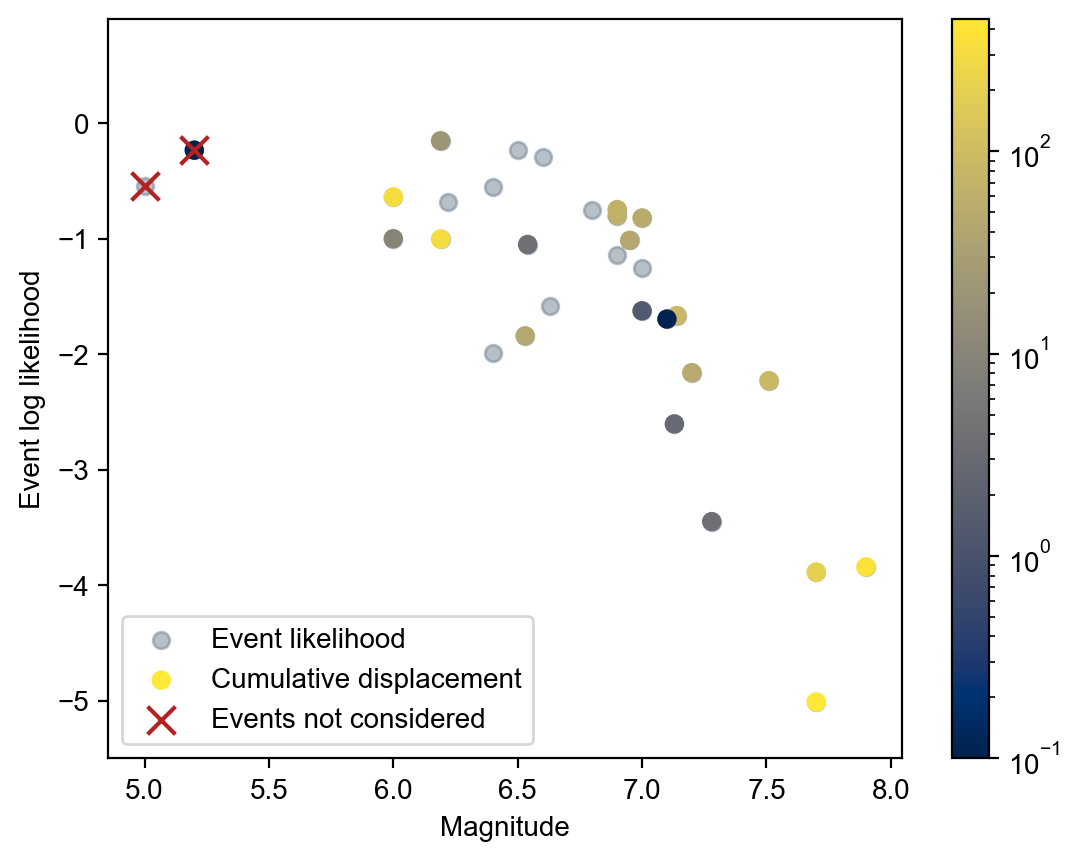

In [72]:
plt.figure()
plt.scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c='slategrey',alpha=0.5,label='Event likelihood')#,edgecolors='slategrey')

# for i in range(len(event_group)):
#     plt.annotate(event_group[i], (mag[i], event_likelihood[i]+np.log10(p_continue_straight)*SRL[i]),fontsize=8)

plt.scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c=cumdisp,cmap='cividis',label='Cumulative displacement',norm=mcolors.LogNorm())
plt.colorbar()

idx = np.where(mag < 6) # remove outliers, will work on map consistency later
plt.scatter(mag[idx],event_likelihood[idx]+np.log10(p_continue_straight)*SRL[idx],c='firebrick',marker='x',s=100,label='Events not considered')
mag_del = np.delete(mag, idx)
cumdisp = np.delete(cumdisp,idx)
event_likelihood_del = np.delete(event_likelihood, idx)
SRL_del = np.delete(SRL, idx)
all_info = stats.linregress(mag_del, event_likelihood_del+np.log10(p_continue_straight)*SRL_del)

##### fit data with linear regression in semilog space (pwl bc mag is logged already)
slope, intercept, r_value, p_value, std_err = stats.linregress(mag_del, event_likelihood_del+np.log10(p_continue_straight)*SRL_del)

# Define the x range for the line plot
x_range = np.linspace(min(mag_del), max(mag_del), 100)

# Calculate the y values for the line plot
y_range = slope * x_range + intercept

# Plot the data and the line fit with error bars
ax[0].plot(x_range, y_range, label=r"$P_{EQ} = %.2f \pm %.2f L^{%.2f \pm  %.2f}$" % (intercept,all_info.intercept_stderr,slope,all_info.stderr),linestyle=':',c='darkorange')

plt.ylim([-5.5, 0.9])
plt.ylabel('Event log likelihood')
plt.xlabel('Magnitude')
plt.legend()
plt.savefig('GRL/mag_likelihood_displacement.pdf')

-1.8308927705071578 10.9431987644205 1.986603122911795
a = -1.831 +/- 0.290
b = 10.943 +/- 1.987
a = 7.390 +/- 1.457
b = -1.986 +/- 0.321


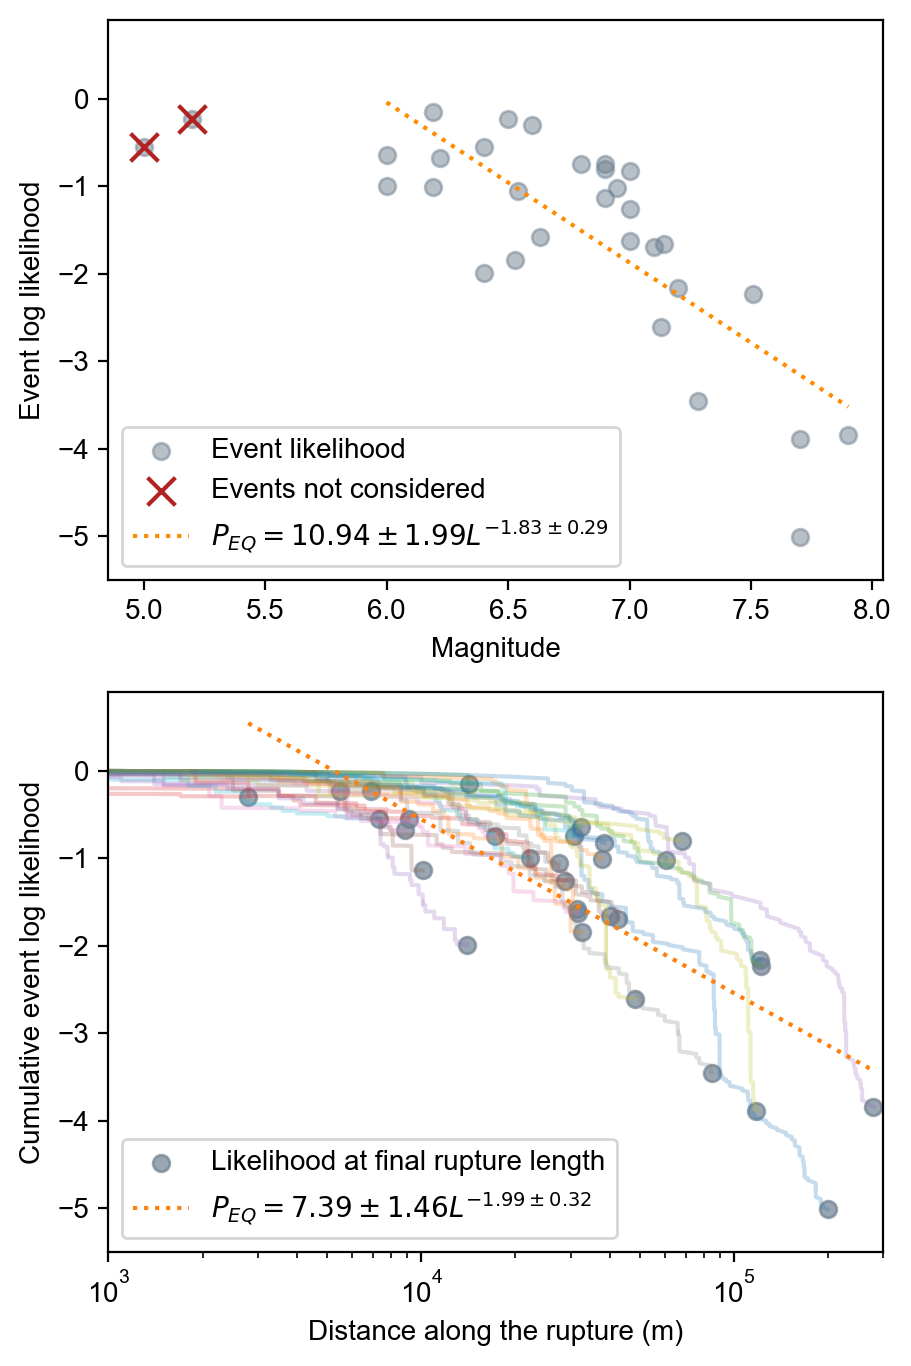

In [73]:
fig, ax= plt.subplots(2,1,figsize=(5,8))
ax[0].scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c='slategrey',alpha=0.5,label='Event likelihood')#,edgecolors='slategrey')

# for i in range(len(event_group)):
#     plt.annotate(event_group[i], (mag[i], event_likelihood[i]+np.log10(p_continue_straight)*SRL[i]),fontsize=8)

# ax[0].scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c=cumdisp,cmap='cividis',label='Number of segments',norm=mcolors.LogNorm())
# plt.colorbar(ax=ax[0])

idx = np.where(mag < 6) # remove outliers, i.e., events too small for proper rupture propagation to the surface
ax[0].scatter(mag[idx],event_likelihood[idx]+np.log10(p_continue_straight)*SRL[idx],c='firebrick',marker='x',s=100,label='Events not considered')
mag_del = np.delete(mag, idx)
cumdisp = np.delete(cumdisp,idx)
event_likelihood_del = np.delete(event_likelihood, idx)
SRL_del = np.delete(SRL, idx)

##### fit data with linear regression in semilog space (pwl bc mag is logged already)
all_info = stats.linregress(mag_del, event_likelihood_del+np.log10(p_continue_straight)*SRL_del)
# slope, intercept, r_value, p_value, std_err, intercept_stderr
print(all_info.slope,all_info.intercept, all_info.intercept_stderr)

# Define the x range for the line plot
x_range = np.linspace(min(mag_del), max(mag_del), 100)

# Calculate the y values for the line plot
y_range = slope * x_range + intercept

# Plot the data and the line fit with error bars
ax[0].plot(x_range, y_range, label=r"$P_{EQ} = %.2f \pm %.2f L^{%.2f \pm  %.2f}$" % (intercept,all_info.intercept_stderr,slope,all_info.stderr),linestyle=':',c='darkorange')
#ax[0].fill_between(x_range, y_range - std_err, y_range + std_err, alpha=0.2,color='darkorange',label='Standard error')

ax[0].set_ylim([-5.5, 0.9])
ax[0].set_ylabel('Event log likelihood')
ax[0].set_xlabel('Magnitude')
ax[0].legend()

# # Print the fitted parameters and errors
print("a = {:.3f} +/- {:.3f}".format(all_info.slope,all_info.stderr))
print("b = {:.3f} +/- {:.3f}".format(all_info.intercept, all_info.intercept_stderr))

######################################################## cumulative probability

lastpt = []
keeplikelihood = event_likelihood+np.log10(p_continue_straight)*SRL

for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    subsetb = subsetb.reset_index(drop=True)
    subsetb['PR'] = subsetb['PR'].astype(float)

    gatelikelihood = subsetb['PR']
    gateloglikelihood = np.log10(subsetb['PR'])
    
    gateloc = subsetb['Location along rupture']
    subsetb['Approx_Location'] = subsetb['Location along rupture'].round().astype(int)

    SRL_event = subsetb['Total rupture length']   
    surf_length = SRL_event[0]
    surf_length = round(surf_length)
    probframe = pd.DataFrame()
    SRL_points = list(range(surf_length))
    new_rows = pd.DataFrame({'surf_length': SRL_points})
    probframe = probframe.append(new_rows, ignore_index=True)
    probframe['prob_straight_segment'] = p_continue_straight
    merged_df = pd.merge(probframe, subsetb, left_on='surf_length', right_on='Approx_Location', how='left')
    merged_df['prob'] = merged_df.apply(lambda row: row['PR'] if not pd.isnull(row['PR']) else row['prob_straight_segment'], axis=1)
    merged_df['cumulative_sum'] = np.log10(merged_df['prob']).cumsum()

    lastpt.append(max(SRL_points))

    # now we plot the data and fit the model:    
    sns.lineplot(data=merged_df,x=merged_df['surf_length'],y=merged_df['cumulative_sum'],palette="blend:#7AB,#EDA",alpha=0.25,ax=ax[1]) 

ax[1].scatter(lastpt,keeplikelihood,c='slategrey',alpha=0.7,label='Likelihood at final rupture length')
# ax[1].scatter(lastpt[idx],keeplikelihood[idx],c='firebrick',marker='x',s=100,label='Events not considered')

# for i in range(len(event_group)):
#     plt.annotate(event_group[i], (lastpt[i], keeplikelihood[i]),fontsize=8)

ax[1].set_xscale('log')
ax[1].set_ylabel('Cumulative event log likelihood')
ax[1].set_xlabel('Distance along the rupture (m)')
ax[1].set_xlim([1000, 300000])
ax[1].set_ylim([-5.5, 0.9])

lastpt = np.delete(lastpt,idx)
keeplikelihood = np.delete(keeplikelihood,idx)

# # Define the power-law function
def power_law(x, a, b):
     return b*np.log10(x)+a

# # Fit the data to the power-law function
popt, pcov = curve_fit(power_law, lastpt, keeplikelihood)

# # Calculate the errors
perr = np.sqrt(np.diag(pcov))

# # Print the fitted parameters and errors
print("a = {:.3f} +/- {:.3f}".format(popt[0], perr[0]))
print("b = {:.3f} +/- {:.3f}".format(popt[1], perr[1]))

# # Plot the power-law fit
xfit = np.linspace(min(lastpt),max(lastpt), 1000)
yfit = power_law(xfit, *popt)
ax[1].plot(xfit, yfit, label=r"$P_{EQ} = %.2f \pm %.2f L^{%.2f \pm  %.2f}$" % (popt[0],perr[0], popt[1],perr[1]),linestyle=':')

# # Show the plot
ax[1].legend()
plt.savefig('GRL/mag_dependence_CDF_likelihood.pdf')
plt.show()

# Earthquake gates along rupture analysis

In [74]:
def gate_distribution_along_strike(groupid,type,length_or_angle,axesid,ylabel,palette):

    EQgate = grouped.get_group(groupid)

    if type == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        single = grouped_stress.get_group('single')
        feature = single['Length (m) or angle (deg)']
        normalized_loc = single['Normalized location']

    elif type == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        double = grouped_stress.get_group('double')
        feature = double['Length (m) or angle (deg)']
        normalized_loc = double['Normalized location']

    else:
        feature = EQgate['Length (m) or angle (deg)']
        normalized_loc = EQgate['Normalized location']
    
    if length_or_angle == 'length':
        yfeature = np.log10(feature)

    elif length_or_angle == 'angle':
        yfeature = feature

    else: 
        KeyError("Feature must include a length or an angle")

    # now we plot the data and fit the model:    
    sns.scatterplot(data=EQgate,x=normalized_loc,y=yfeature,hue=EQgate['Breached or unbreached'],palette=palette, edgecolor='none',alpha=0.8, ax=axesid,legend='')
    axesid.set_ylabel(ylabel)
    axesid.set_xlabel('Normalized distance along the rupture')


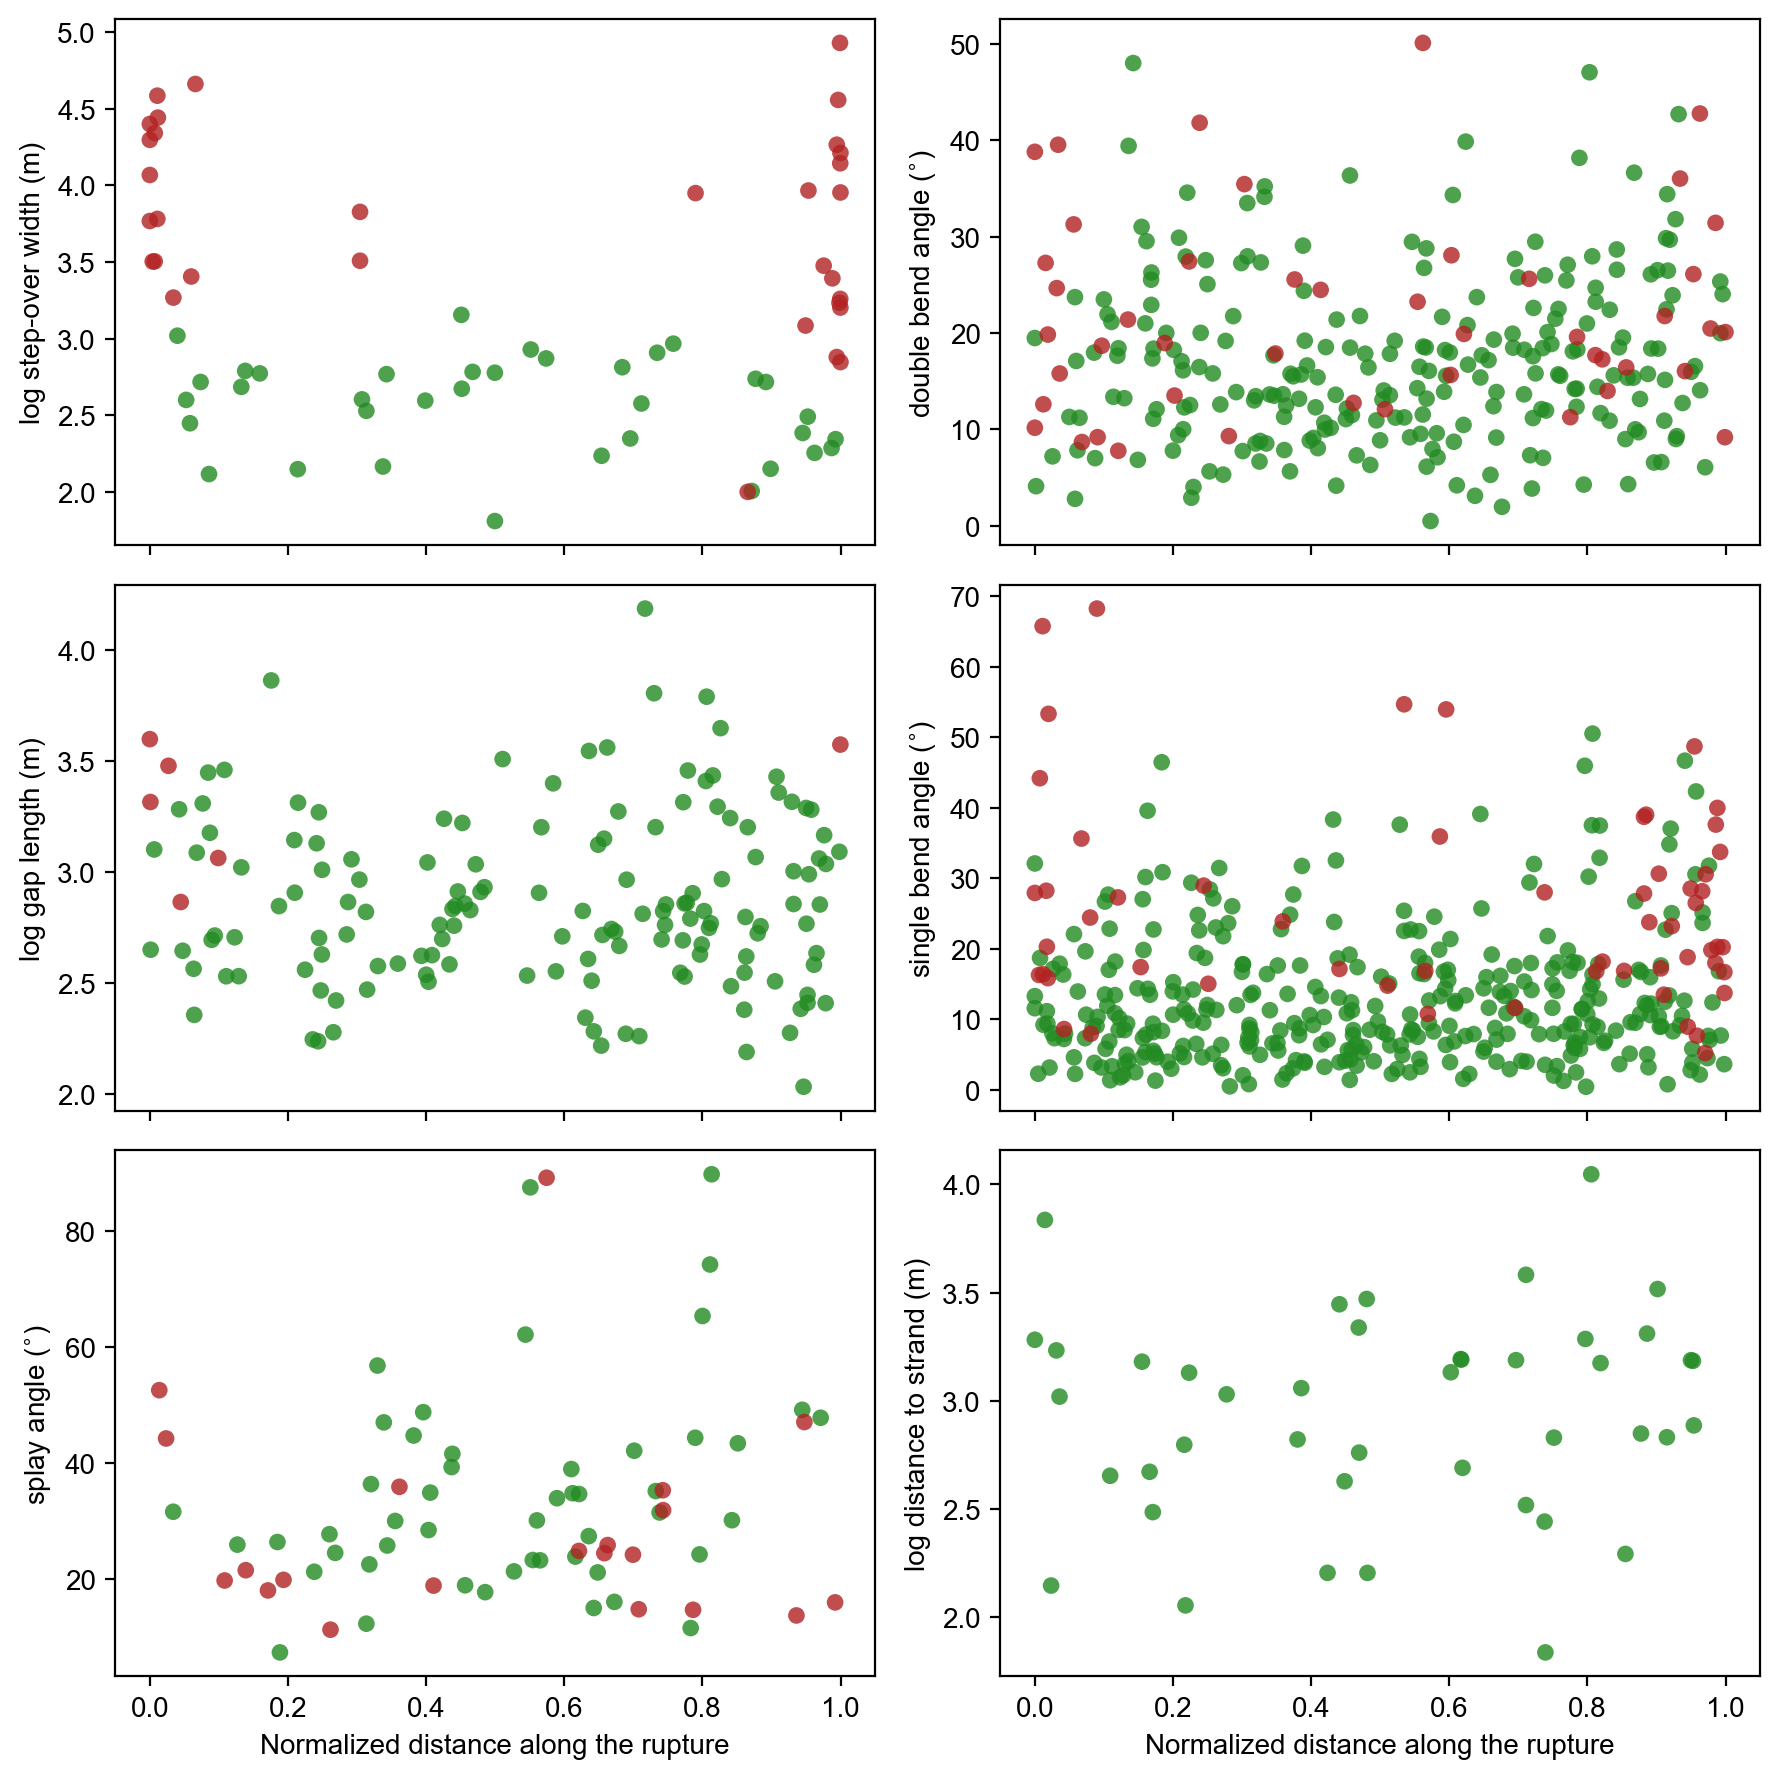

In [75]:
fig, axes = plt.subplots(3,2,figsize=(9, 9),sharex=True)
palette = {'breached': 'forestgreen', 'unbreached': 'firebrick'}
gate_distribution_along_strike('stepover','none','length',axes[0,0],'log step-over width (m)',palette)
gate_distribution_along_strike('bend','double','angle',axes[0,1],'double bend angle ($^{\circ}$)',palette)
gate_distribution_along_strike('bend','single','angle',axes[1,1],'single bend angle ($^{\circ}$)',palette)
gate_distribution_along_strike('gap','none','length',axes[1,0],'log gap length (m)',palette)
gate_distribution_along_strike('splay','none','angle',axes[2,0],'splay angle ($^{\circ}$)',palette)
gate_distribution_along_strike('strand','none','length',axes[2,1],'log distance to strand (m)',palette)
plt.tight_layout()
plt.savefig('GRL/Normalized_dist_size.pdf')
plt.show()


## Comparison to previous studies

In [76]:
def calculate_center(numbers):
    center_values = []
    for i in range(len(numbers) - 1):
        center = (numbers[i] + numbers[i + 1]) / 2.0
        center_values.append(center)
    return center_values

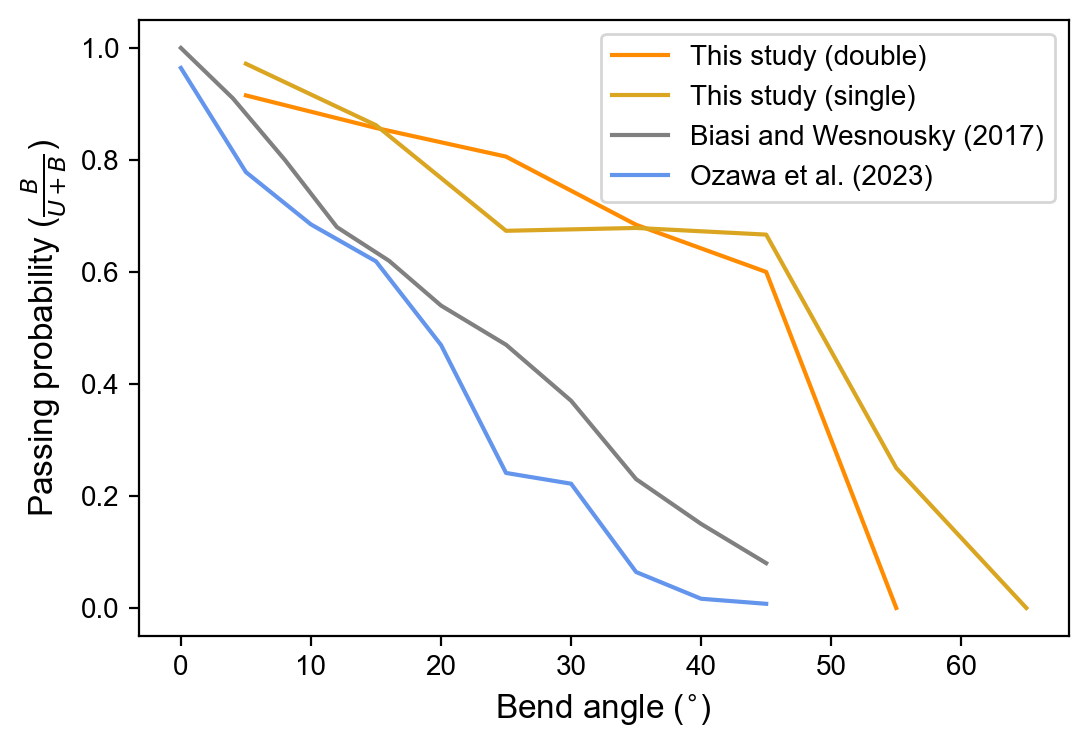

In [77]:
group = grouped.get_group('bend')
selectB= group.groupby(group["Type (single or double)"])
double = selectB.get_group('double')
double['Bin'] = pd.cut(double['Length (m) or angle (deg)'], bins=np.linspace(0,90,10)) 
double['Bin Middle'] = double['Bin'].apply(lambda x: (x.left + x.right) / 2)

breached_counts = double[double['Breached or unbreached'] == 'breached'].groupby('Bin Middle').size()

# Count the occurrences of 'unbreached' for each value of 'Bin Middle'
unbreached_counts = double[double['Breached or unbreached'] == 'unbreached'].groupby('Bin Middle').size()

ratio = (breached_counts/(unbreached_counts+breached_counts))

unique_values = np.linspace(0,90,10)
unique_values = calculate_center(unique_values)

plt.figure(figsize=(6,4))
plt.plot(unique_values,ratio,c='darkorange',label='This study (double)')

group = grouped.get_group('bend')
selectB= group.groupby(group["Type (single or double)"])
single = selectB.get_group('single')
single['Bin'] = pd.cut(single['Length (m) or angle (deg)'], bins=np.linspace(0,90,10)) 
single['Bin Middle'] = single['Bin'].apply(lambda x: (x.left + x.right) / 2)

breached_counts = single[single['Breached or unbreached'] == 'breached'].groupby('Bin Middle').size()

# Count the occurrences of 'unbreached' for each value of 'Bin Middle'
unbreached_counts = single[single['Breached or unbreached'] == 'unbreached'].groupby('Bin Middle').size()

ratio = (breached_counts/(unbreached_counts+breached_counts))

unique_values = np.linspace(0,90,10)
unique_values = calculate_center(unique_values)
plt.plot(unique_values,ratio,c='goldenrod',label='This study (single)')

# load data from Biasi and Wesnousky (2017) and Okawa et al. (2023)
Bend_angle_Biasi = np.array([0, 4, 8, 12, 16, 20, 25, 30, 35, 40, 45])
PP_Biasi = np.array([1, 0.91, 0.80, 0.68, 0.62, 0.54, 0.47, 0.37, 0.23, 0.15, 0.08])

Bend_angle_Ozawa = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
PP_Ozawa = np.array([0.96428571, 0.77829376, 0.68489335, 0.61890165, 0.46959471, 0.24105128, 0.22185883, 0.06410775, 0.01640081, 0.00738151])

plt.plot(Bend_angle_Biasi, PP_Biasi,'gray',label='Biasi and Wesnousky (2017)')
plt.plot(Bend_angle_Ozawa,PP_Ozawa,'cornflowerblue', label='Ozawa et al. (2023)')
plt.ylabel(r'Passing probability ($\frac{B}{U+B}$)',fontsize=12)
plt.xlabel(r'Bend angle ($^{\circ}$)',fontsize=12)
plt.legend()
plt.savefig('GRL/bendPPcomparisons.pdf')

# Earthquake gate size vs distance to event epicenter

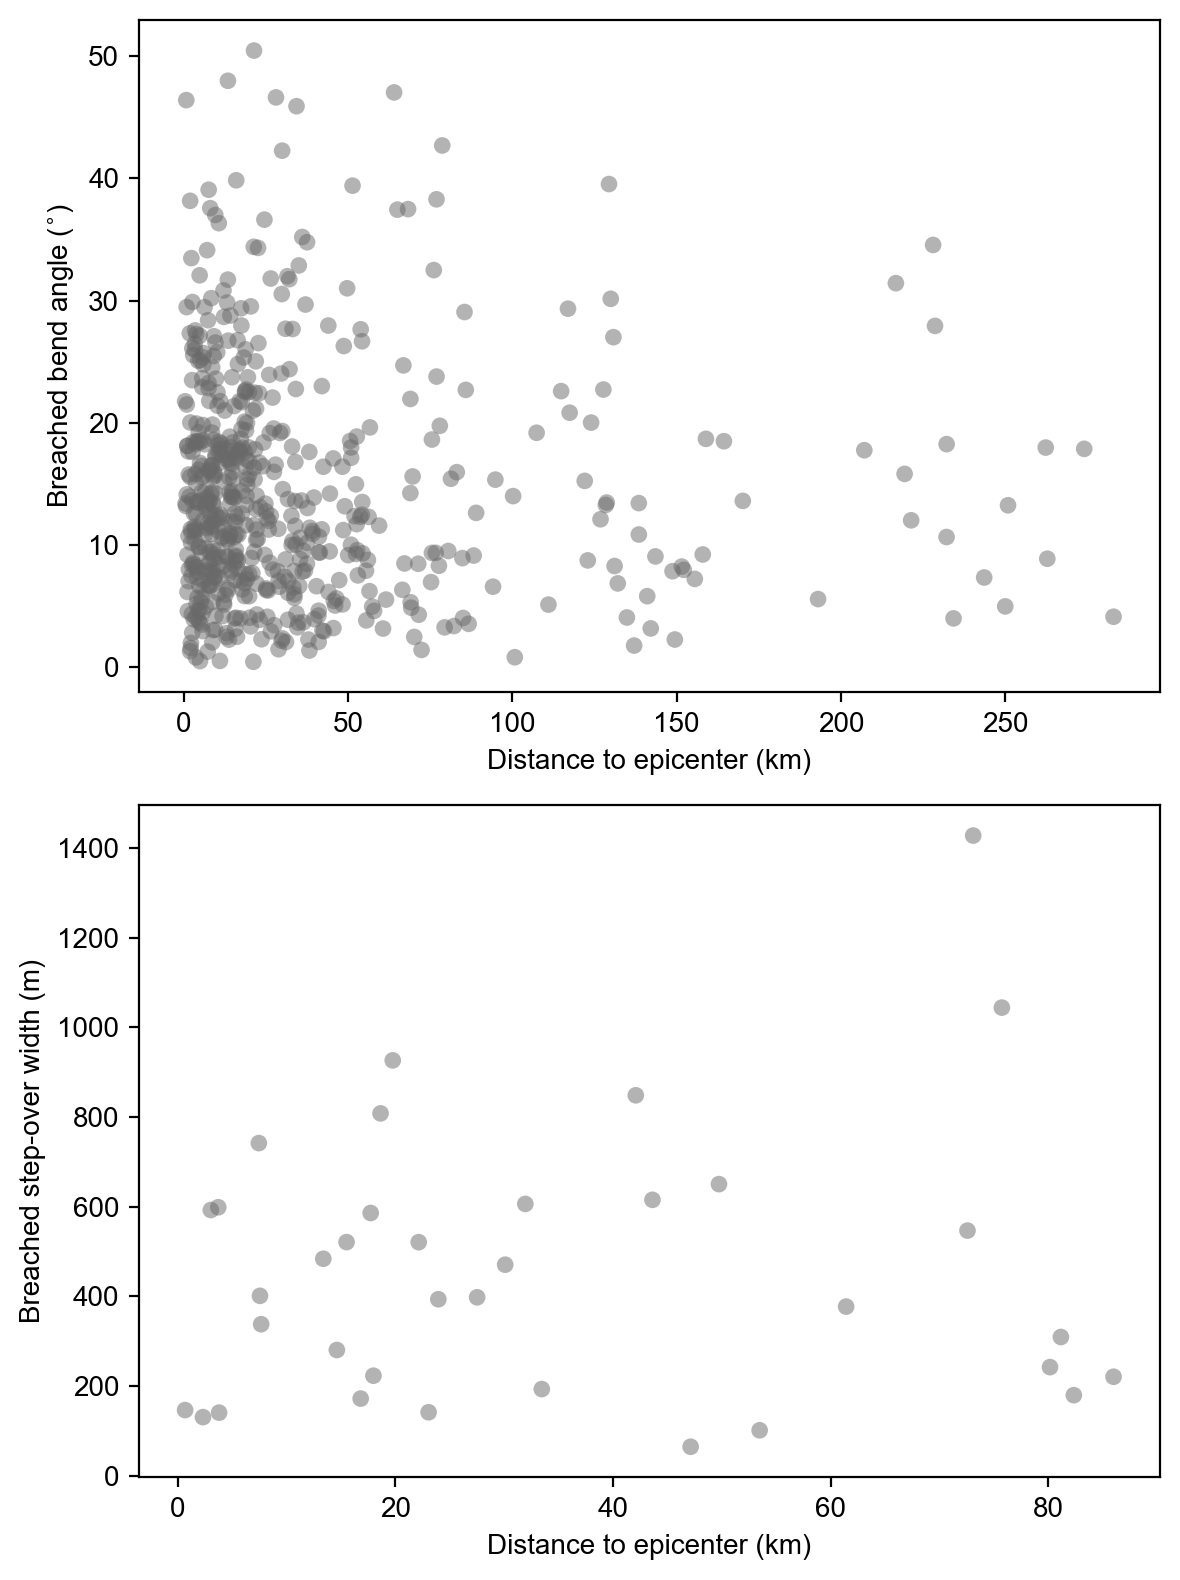

In [80]:
# Filter data for 'breached' feature types
data_filt = data#[data['Distance to epicenter'] >= 350000]

breached_data = data_filt[(data_filt['Breached or unbreached'] == 'breached') &
                          data_filt['Feature'].isin(['stepover', 'bend'])]

# Get the unique categories in the filtered data
unique_categories = breached_data['Feature'].unique()

# Create subplots for each unique category
num_categories = len(unique_categories)
fig, axes = plt.subplots(nrows=num_categories, figsize=(6, 4*num_categories))

# Iterate through each unique category and create a subplot
for i, category in enumerate(unique_categories):
    ax = axes[i] if num_categories > 1 else axes  # Use the appropriate subplot object
    category_data = breached_data[breached_data['Feature'] == category]
    
    ax.scatter(category_data['Distance to epicenter']/1000, category_data['Length (m) or angle (deg)'],c='dimgray',alpha=0.5,edgecolors='none')
    ax.set_xlabel('Distance to epicenter (km)')
    if category == 'stepover':
        ax.set_ylabel('Breached step-over width (m)')
        
    elif category == 'bend':
        ax.set_ylabel(r'Breached bend angle ($^{\circ}$)')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('GRL/Gatesize_vs_epicenter_distance.pdf')
plt.show()